# Adaptive PDE discretizations on Cartesian grids
## Volume : Divergence form PDEs
## Part : Linear elasticity
## Chapter : Fourth order schemes for anisotropic acoustic and elastic waves

$
\newcommand\bbone{\mathbb 1}\newcommand\sm{\setminus}
\newcommand\<{\langle}\newcommand\>{\rangle}
\newcommand\vp{\varphi}
\newcommand\diff{\mathrm d}\newcommand\Diff{\mathrm{D}}
\DeclareMathOperator\Id{Id}\DeclareMathOperator\len{len}\DeclareMathOperator\Tr{Tr}
\newcommand\kF{\mathfrak F}
\newcommand\cL{\mathcal L}\newcommand\cF{\mathcal F}\newcommand\cO{\mathcal O}\newcommand\cS{\mathcal S}
\newcommand\cD{\mathcal D}
\newcommand\bQ{\mathbb Q}\newcommand\bR{\mathbb R}\newcommand\bS{\mathbb S}\newcommand\bZ{\mathbb Z}
\newcommand\ve{\varepsilon}
\newcommand\kg{\mathrm{kg}}
\newcommand\diver{\mathrm{div}}\newcommand\kw{\mathrm{k}}
$

We illustrate numerical schemes for the acoustic and elastic wave equations, in one to three dimensions.
These topics are also discussed in the [notebook on the one dimensional case](Time1D_div.ipynb), and the two notebooks on the [elastic energy discretization](ElasticEnergy.ipynb) and [elastic wave equation](ElasticWave.ipynb). 
The present notbook comes with the following aspects in mind:
- Second and fourth order finite differences schemes in space.
- Second and fourth order symplectic schemes in time.
- Exact conservation of a (perturbed) discrete Hamiltonian.
- Absorbing boundary conditions.
- Adjoint operators.
- Changes of variables, eventually used for e.g. taking topography into account.
- Code acceleration with specialized GPU kernels.

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. One dimension](#1.-One-dimension)
    * [1.1 Spatial discretization](#1.1-Spatial-discretization)
    * [1.2 Time discretization](#1.2-Time-discretization)
    * [1.3 Constant coefficients](#1.3-Constant-coefficients)
    * [1.4 Acoustic change of variables](#1.4-Acoustic-change-of-variables)
    * [1.5 Elastic change of variables](#1.5-Elastic-change-of-variables)
    * [1.6 Damping](#1.6-Damping)
    * [1.7 (Symplectic) Adjoint operators](#1.7-(Symplectic)-Adjoint-operators)
    * [1.8 Automatic differentiation of the Hamiltonian](#1.8-Automatic-differentiation-of-the-Hamiltonian)
  * [2. Two dimensional acoustic waves](#2.-Two-dimensional-acoustic-waves)
    * [2.1 Constant coefficients](#2.1-Constant-coefficients)
    * [2.2 Change of variables](#2.2-Change-of-variables)
  * [3. Two dimensional elastic waves](#3.-Two-dimensional-elastic-waves)
    * [3.1 Construction of an exact solution](#3.1-Construction-of-an-exact-solution)
    * [3.2 Change of variables](#3.2-Change-of-variables)
  * [4. GPU accelerated kernels](#4.-GPU-accelerated-kernels)
    * [4.1 Acoustic wave](#4.1-Acoustic-wave)
    * [4.2 Elastic wave](#4.2-Elastic-wave)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HighOrderWaves','Div'))

In [2]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Metrics import Riemann
from agd.Metrics.Seismic import Hooke
from agd.ODE.hamiltonian import QuadraticHamiltonian
from agd import AutomaticDifferentiation as ad
from agd import Selling
mica,_ = Hooke.mica # Note: ρ is in g/cm^3, which is inconsistent with the Hooke tensor SI units 
norm = ad.Optimization.norm

In [3]:
import copy
import numpy as np; xp=np; allclose=np.allclose; π = np.pi
import matplotlib.pyplot as plt

### 0.1 Additional configuration

Uncomment the following line to run the code on the GPU.

**Important :** In order to get actual performance improvements, specialized GPU kernels are needed, as illustrated in the end of the notebook. Sparse matrix based implementations, which are enabled by the next line, are not very efficient usually and are only for compatibility checks.

In [4]:
#xp,plt,mica,allclose = map(ad.cupy_friendly,(xp,plt,mica,allclose))

## 1. One dimension

### 1.1 Spatial discretization

**Hamiltonian.**
The discretization of the one-dimensional wave equation is introduced in more detail in the [dedicated notebook](Time1D_div.ipynb). 

Consider the domain $X = [0,1]$, with periodic boundary conditions for now. The Hamiltonian of the continuous system reads
$$
    H_c(q,p) := \frac 1 2 \int_X \Big(\frac {p(x)^2} {\rho(x)} + D(x) q'(x)^2\Big) \diff x.
$$
This Hamiltonian may represent the energy of an elastic band, in the linearized regime. The first term accounts for the kinetic energy, and the second term accounts for the elastic energy, with the following interpretations : 
- $q$, referred to as the system "position", is an infinitesimal displacement of the elastic band.
- $p$, referred to as the system "impulsion", is a momentum density.
- $\rho$ is the local material density, assumed to be positive (and non-vanishing).
- $D$ is the local elasticity modulus.

In [5]:
def make_domain1(N=100):
    """Returns X, a regular sampling of [0,1] with N points, and h the grid scale."""
    X,dx = xp.linspace(0,1,N,endpoint=False,retstep=True)
    return (X+dx/2),dx

**Discretization.** We discretize this Hamiltonian using a finite difference scheme, whose step size $h>0$ is the inverse of an integer. We denote by $X_h := \{h/2,3h/2,\cdots,1-h/2\}$ the discretized interval.
We recall that, with periodic boundary conditions as we assumed, the summation
$$
    \int_X f(x) \diff x = h \sum_{x\in X_h} f(x) + \cO(h^{2k}),
$$
is spectrally accurate, i.e. the order $2k$ can be arbitrary, provided $f$ is smooth enough. 

The discretization of the *kinetic energy* is therefore straightforward:
$$
    \int_X \frac{p(x)^2}{\rho(x)} \diff x = h\sum_{x\in X_h} \frac {p(x)^2}{\rho(x)} + \cO(h^{2k}),
$$
provided the momentum $p$ and the density $\rho>0$ are smooth enough.

In [6]:
def KineticEnergy_a(p,ρ):
    """
    Kinetic energy (x2), for the acoustic wave equation.
    p : momentum. ρ : density.
    """
    return 0.5 * p**2 / ρ # Return energy density, summation will be implicit

**Finite differences.** The discretisation of the acoustic potential energy requires us to approximate the squared derivative $q'^2$. 

The simplest and most classical scheme uses upwind and downwind finite differences:
$$
   q'(x)^2 = \frac 1 {2h^2} \Big[ (q(x-h)-q(x))^2 + (q(x+h)-q(x))^2 \Big] + \cO(h^2).
$$
The scheme is second order accurate for $q'(x)^2$, even though it is defined in terms of first order accurate finite differences (downwind and upwind) for $q'(x)$, thanks to a cancellation effect due to symmetry.

An fourth order accurate scheme for $q'(x)^2$ can likewise be obtained as a combination of second order accurate schemes for $q'(x)$ (downwind, centered, and upwind), as follows
$$
    q'(x)^2 = \frac 1 {24 h^2} \Big[ (-q(x-2h)+4q(x-h)-3q(x))^2 + 4(q(x+h)-q(x-h))^2 + (-q(x+2h)+4q(x+h)-3q(x))^2 \Big] + \cO(h^4).
$$
Note that the coefficients of $q(x) q(x-2h)$ and $q(x) q(x+2h)$ are positive, which means that the scheme is not monotone, as can be expected for a scheme of order $>2$.

**Additional parameters $\alpha$ and $S$** in the functions below. Their relevance will be made clear in section [1.5 Elastic change of variables](#1.5-Elastic-change-of-variables).

In [7]:
help(fd.DiffEll)

Help on function DiffEll in module agd.FiniteDifferences:

DiffEll(u, offset, gridScale=1.0, order=2, α=0.0, **kwargs)
    Helper function for discretizing (<grad u,e> - α)^2, which appears in elliptic energies. Returns
    $$
        [u(x)-u(x-h*e)-αh, u(x+h*e)-u(x)-αh]/(h sqrt(2))
    $$
    if order=2. Sum the squares to approximate (<grad u,e>-α)^2. Also accepts order=4.



In [8]:
def PotentialEnergy1a(q,D,dx,order=2,S=0.):
    """One dimensional acoustic potential energy density (x2)"""
    offset = xp.array([1])
    diff = fd.DiffEll(q,offset,dx,order,α=S*q,padding=None) # padding=None means periodic
    return 0.5 * D*diff**2 # Summation is implicit

**Full discretized Hamiltonian.** We omit for simplicity the scaling factor $h$ in the discretization of the integrals.

The discretized Hamiltonian $H_d$ may be expressed as 
$$
    H_d(q,p) = \frac 1 2 \Big(p^\top A p + q^\top B q\Big),
$$
where : 
- the position $q$ and momentum $p$ defined over $X_h$ are seen as vectors $q,p \in \bR^N$ with $N=1/h$.
- the matrices $A$ and $B$ are positive semi-definite.

Note that by construction $A$ is a diagonal matric with the material density $\rho$ as entries, whereas $B$ is a sparse finite element matrix.

In [9]:
def Hamiltonian1a(ρ,D,X,dx,order=2,S=0.):
    """Discretized Hamiltonian of the one dimensional acoustic wave equation."""
    Hq = lambda q: PotentialEnergy1a(q,D,dx,order=order,S=S) 
    Hp = lambda p: KineticEnergy_a(p,ρ)
    H = QuadraticHamiltonian(Hq,Hp)
    H.set_spmat(xp.zeros_like(X)) # Replaces quadratic functions with sparse matrices
    return H

**Comparison of the kinetic and elastic energies.**
In order to evaluate the Courant-Friedrichs-Levy (CFL) stability condition, for the time step of the discretized ODE below, we need to compare the matrices $A$ and $B$. Specifically, we need a constant $\tau>0$ such that 
$$
    A^{-1} \succeq \tau^2 B
$$
in the sense of symmetric positive definite matrices. Note that $A$ is diagonal with positive entries, hence is invertible.
The above inequality implies, again in the sense of positive definite matrices
\begin{align*}
    B &\succeq \tau B A B, &
    A \succeq \tau A B A.
\end{align*}

Using the arithmetic-geometric mean inequality $(a+b)^2 \leq 2(a^2+b^2)$ we obtain 
$$
    (q(x-h)-q(x))^2 + (q(x+h)-q(x))^2 \leq 2 q(x-h)^2 + 4 q(x)^2 + 2 q(x+h)^2.
$$
Likewise, using $(\alpha a+\beta b+\gamma c)^2\leq (\alpha+\beta+\gamma)(a^2+b^2+c^2)$ for any positive weights $\alpha,\beta,\gamma$, we obtain
\begin{align*}
&(-q(x-2h)+4q(x-h)-3q(x))^2 + 4(q(x+h)-q(x-h))^2 + (-q(x+2h)+4q(x+h)-3q(x))^2 \\
& \leq 8 q(x-2h)^2+40 q(x-h)^2+ 24 q(x)^2 + 40 q(x+h)^2 + 8 q(x+2h)^2,
\end{align*}
where $40 = 8\times 4+4\times 2$ and $24 = 8 \times 3$.

Since the scheme is local, and the density $\rho$ and elasticity $D$ are assumed to be continuous over the domain $X$, we can limit our attention to the case where they are constant. Summing the above estimates over all translates at points $x\in X_h$  we obtain the sufficient condition (ensures $A^{-1} \succeq \tau B$)
$$
    \rho \geq c_{k} \tau^2 D / h^2
$$
where $c_2 = (2+4+2)/2 = 4$ for the second order scheme, and $c_4 = (8+40+24+40+8)/24 = 6$ for the fourth order scheme.

*Dimensional analysis.* 
Denote by $m$ (meter), $\kg$ (kilogram), $s$ (second) and $J$ (joule) the usual SI units. 
Then $[\rho] = \kg/m^d$, $[D] = J/m^d = \kg\, m^{2-d} s^{-2}$, $[h]=m$.

It follows that $[\tau] = s$ has the dimension of a time. Note also that $c = \sqrt{D/\rho}$ has the dimension $[c] = m/s$ of a velocity, namely the velocity of waves.

### 1.2 Time discretization

**Time evolution.** 
Let us recall Hamilton's equation of evolution : 
\begin{align*}
    \dot q &= \partial_p H, &
    \dot p &= -\partial_q H.
\end{align*}
The wave evolution PDE is obtained as Hamilton's equations applied to the wave Hamiltonian. By construction, the Hamiltonian value is preserved along the evolution:
$$
    H(q(t),p(t)) = \mathrm{cst}.
$$

**The Euler first order symplectic scheme,** is first order accurate, and preserves the Hamiltonian $2 H_E(q,p) = p^\top A p + q^\top B q + \delta p^\top A B q$, see [this notebook for details](Time1D_div.ipynb).

**The Verlet second order symplectic scheme.**
The Verlet update $(q,p) \mapsto (q',p'')$ is defined by two implicit updates of the impulsion $p$ and one explicit update of the position $q$, as follows: 
\begin{align}
    p' &= p - \tfrac \delta 2 \partial_q H(q,p'), &
    q' &= q + \delta \partial_p H(q,p'), & 
    p'' &= p' - \tfrac \delta 2 \partial_q H(q',p'').
\end{align}
Fortunately in the considered case of the Wave equation, whose Hamiltonian is separable and quadratic, these updates are in fact explicit and linear:
\begin{align*}
    p' &= p - \tfrac \delta 2 B q, &
    q' &= q + \delta A p', & 
    p'' &= p' - \tfrac \delta 2 B q'.
\end{align*}
The Verlet scheme is second order accurate in time, and exactly preserves the following perturbed discrete Hamiltonian
$$
    H_V(q,p) := \frac 1 2 \Big(p^\top A p + q^\top (B - \tfrac 1 4 \delta^2 B A B) q\Big).
$$
*CFL condition.* The quadratic form $H_V$ is positive semi-definite provided $B\succ \tfrac 1 4 \delta^2 B A B$, which holds provided 
$
\delta \leq 2\tau.
$
If this condition is satisfied strictly, then $H_V$ is equivalent to the discretized Hamiltonian $H_d$, which encodes the total energy of the system, and thus the evolution is stable.

**The Ruth fourth order symplectic scheme (1983).**
This is a symplectic scheme, similar to the Verlet scheme, but with 7 substeps instead of 3.
This scheme is fourth order accurate, and exactly preserves the following perturbed discrete Hamiltonian
$$
    2 H_R(q,p):= p^\top A p + q^\top B q + 
    \sum_{1\leq k \leq 4} \alpha_k \delta^{2k} p^\top A (BA)^k p + \sum_{1\leq k \leq 5} \beta_k \delta^{2k} q^\top B (AB)^k q 
$$

with coefficients $(\alpha_1,\cdots,\alpha_4) \approx (- 0.333496,-0.164001,0.0319671,0.00919193)$, and $(\beta_1,\cdots,\beta_5) \approx (- 0.333496, -0.0878906, 0.0630550,0.00539940,0.00419557)$. These coefficients are algebraic numbers with explicit (but longish) expressions. 

*CFL condition.*  Noting that $\alpha_3,\alpha_4,\beta_3,\beta_4,\beta_5\geq 0$, and that the corresponding sum terms are positive semi-definite. We thus arrive at the CFL condition
\begin{align*}
    1 &\geq \alpha_1(\delta/\tau)^2 + \alpha_2(\delta/\tau)^4, &
    1 &\geq \beta_1(\delta/\tau)^2 + \beta_2(\delta/\tau)^4,
\end{align*}
which holds provided $\delta \leq k \tau$ with $k \approx 1.28596$.




<!---
\begin{align*}
\delta &\leq \tau / \sqrt{\alpha}, & \alpha &= 0.333496\ldots
\end{align*}


with coefficients $(\alpha_1,\cdots,\alpha_4) \approx (- 0.33349609375,-0.16400146484375,0.0319671630859375,0.009191930294036865)$, and $(\beta_1,\cdots,\beta_5) \approx (- 0.33349609375, -0.087890625, 0.06305503845214844,0.0053994059562683105,0.0041955700144171715)$.

*CFL condition.* The quadratic form $H_R$ is positive definite provided $A \geq \alpha \delta^2 A B A$ and $B\geq \alpha \delta^2 B A B$, since the sum terms are positive semi-definite. Thus it suffices that $A^{-1} \geq \alpha \delta^2 B$, which itself is a consequence of 
$
\delta \leq \tau / \sqrt{\alpha}
$
where $\alpha = 0.333496\ldots$

--->

*Efficient implementation.* If the Verlet or Ruth4 scheme is iterated several times, then the first and last substeps updating $p$ can be merged. For the problem at hand, the numerical complexity of the Verlet (or Euler) scheme is dominated by $1$ matrix-vector product $B q$ for each full time step, and three such products for the Ruth4 scheme.

The implementation of the Verlet and Ruth4 scheme, and corresponding perturbed Hamiltonians, are rather straightforward, but for simplicity we will use those provided within the agd library.

In [10]:
#Likewise replacing Verlet_p with Euler_p or Ruth4_p
help(QuadraticHamiltonian.Verlet_p) # Scheme
help(QuadraticHamiltonian.HVerlet_p) # Perturbed Hamiltonian

Help on function Verlet_p in module agd.ODE.hamiltonian_base:

Verlet_p(self, q, p, δ, niter=1)
    niter time steps of the symplectic Verlet scheme.
    Optional damping steps interleaved.

Help on function HVerlet_p in module agd.ODE.hamiltonian:

HVerlet_p(self, q, p, δ)
    Modified Hamiltonian, preserved by the Verlet_p symplectic scheme



**Conclusion on the CFL.**
Denote by $k$ the order in space, and by $l$ the order in time. Then the CFL stability condition with the schemes above takes the form
$$
    \delta \leq a_k b_l c h,
$$
where $c:=\sqrt{D/\rho}$ is the velocity of waves,
with the constants $a_2=1/2$, $a_4=1/\sqrt{6}$, $b_2=2$, $b_4 \approx 1.28596$. 

In the most favourable case of a second order scheme in space and time, we obtain $\delta \leq c h$. In the least favourable case, of a fourth order scheme in space and time,  $\delta \leq c h /2$ is a sufficient condition.

In [11]:
def CFL_mult(order_x=2,order_t=2):
    """CFL factor coming from the order of the time and spatial discretizations"""
    return (None,None,1/2,None,1/np.sqrt(6))[order_x] * (None,2,2,None,1.28596)[order_t]
    
def CFL1a(ρ,D,dx,**kwargs):
    """
    CFL condition for the one-dimensional acoustic wave equation.
    Constant τ such that A^-1 >= τ B.
    kwargs : see CFL1a
    """
    return dx * np.sqrt(np.min(ρ/D)) * CFL_mult(**kwargs)

### 1.3 Constant coefficients

The exact solution of the one-dimensional wave equation with constant coefficients is a superposition of two travelling waves
\begin{align*}
    q(t,x) &= q_-(x+ct) + q_+(x-ct), &
    p(t,x) &= \rho \partial_t q = \rho c (q'_-(x+ct)-q'_+(x-ct)),
\end{align*}
for suitable $q_-$ and $q_+$. Note that $\rho c = \sqrt{\rho D}$.

We run such an numerical example below, so as to assess the correctness of our scheme.

In [12]:
def deriv(f,s):
    """Evaluate the derivative f'(s) of a univariate function f"""
    s_ad = ad.Dense.identity(constant=s,shape_free=tuple())
    return f(s_ad).gradient(0) # Automatic differentiation

In [13]:
def ExactSol1a(ρ,D,qm,qp):
    """Exact solution of the one dimensional acoustic wave equation."""
    c=np.sqrt(D/ρ)
    def q(t,x): return qm(x+c*t)+qp(x-c*t)
    def p(t,x): return ρ*c*deriv(qm,x+c*t) - deriv(qp,x-c*t)
    return q,p

In [14]:
def qm0(x): return 2*np.cos(4*π*x+1.)+np.cos(8*π*x+2.)
def qp0(x): return 3*np.cos(2*π*x+2.)+np.cos(6*π*x+5.)+0.5*np.cos(10*π*x+3.)

In [15]:
# Parameters
X,dx = make_domain1(100)
ρ=1; D=1;
order_x = 2; order_t = 2

# Time step
dt_max = CFL1a(ρ,D,dx,order_x=order_x,order_t=order_t)
dt = 0.6*dt_max

# Initial conditions
q_exact,p_exact = ExactSol1a(ρ,D,qm0,qp0)
q0 = q_exact(0,X)
p0 = p_exact(0,X)

# Hamiltonian
WaveH = Hamiltonian1a(ρ,D,X,dx,order=order_x)

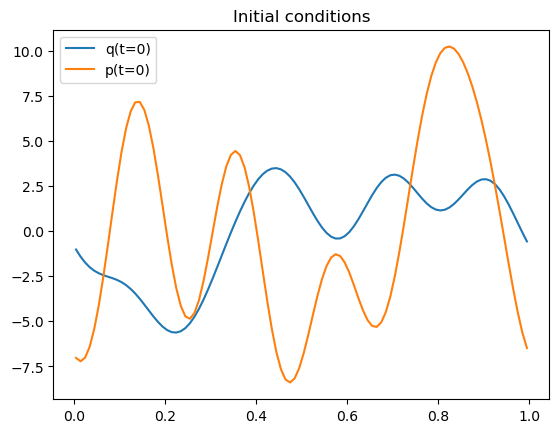

In [16]:
plt.title("Initial conditions")
plt.plot(X,q0,label="q(t=0)")
plt.plot(X,p0/(2*π),label="p(t=0)")
plt.legend();

Set parameters and compute total evolution time.

In [17]:
niter=100
T = niter * dt
q1_exact = q_exact(T,X)
p1_exact = p_exact(T,X)

Solve the ODE numerically. See [how to make nice animations in this notebook](Time1D_div.ipynb).

In [18]:
q1,p1 = WaveH.Verlet_p(q0,p0,dt,niter=100)

The discretized Hamiltonian varies a little bit.

In [19]:
print(f"Discrete Hamiltonian. initial={WaveH.H(q0,p0)}, final={WaveH.H(q1,p1)}.") 

Discrete Hamiltonian. initial=110849.57373439583, final=110850.15226498106.


Whereas the perturbed Hamiltonian is exactly conserved by the evolution, up to machine precision.

In [20]:
print(f"Discrete perturbed Hamiltonian. initial={WaveH.HVerlet_p(q0,p0,dt)}, final={WaveH.HVerlet_p(q1,p1,dt)}.")

Discrete perturbed Hamiltonian. initial=110653.06941303881, final=110653.06941303881.


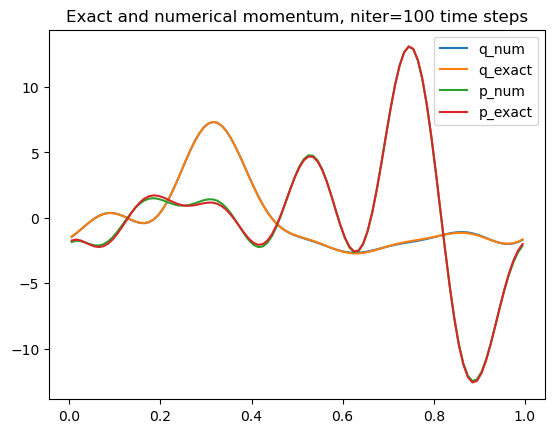

In [21]:
plt.title(f"Exact and numerical momentum, {niter=} time steps")
plt.plot(X,q1,label="q_num")
plt.plot(X,q1_exact,label="q_exact")

plt.plot(X,p1/(2*π),label="p_num")
plt.plot(X,p1_exact/(2*π),label="p_exact")
plt.legend();

In [22]:
print(f"Max relative error, position q : {norm(q1-q1_exact,np.inf)/norm(q1_exact,np.inf):.2g}")
print(f"Max relative error, momentum p : {norm(p1-p1_exact,np.inf)/norm(p1_exact,np.inf):.2g}")

Max relative error, position q : 0.0093
Max relative error, momentum p : 0.019


Let us test the other schemes, systematically.
We confirm that the relevant perturbed discrete Hamiltonian is preserved up to machine precision, and we see that using the 4th order scheme in space and time is approximately $80\times$ more accurate than using the 2nd order scheme in time and space, for this (easy) example.

In [23]:
dt_max = CFL1a(ρ,D,dx,order_x=4,order_t=4) 
dt = 0.6*dt_max
niter=100
T = niter * dt
q1_exact = q_exact(T,X); q1_norm = norm(q1_exact,np.inf)
p1_exact = p_exact(T,X); p1_norm = norm(p1_exact,np.inf)

print(f"Parameters {dx=}, {dt=}, {niter=}, {ρ=}, {D=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian1a(ρ,D,X,dx,order=order_x)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter=niter,order=order_t)
        H_num = WaveH.H_p(q1,p1,dt,order=order_t)
        H_exact = WaveH.H_p(q0,p0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(q1-q1_exact,np.inf)/q1_norm
        p1_relerr = norm(p1-p1_exact,np.inf)/p1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.01, dt=0.003149945829629456, niter=100, ρ=1, D=1.



Parameters order_x=2, order_t=1
H_relerr=9.2e-16, q1_relerr=0.013, p1_relerr=0.04
Parameters order_x=2, order_t=2
H_relerr=-3.9e-16, q1_relerr=0.0058, p1_relerr=0.018
Parameters order_x=2, order_t=4
H_relerr=1.4e-12, q1_relerr=0.0067, p1_relerr=0.019


Parameters order_x=4, order_t=1
H_relerr=-5.2e-16, q1_relerr=0.015, p1_relerr=0.024
Parameters order_x=4, order_t=2
H_relerr=-5.2e-16, q1_relerr=0.00081, p1_relerr=0.0015
Parameters order_x=4, order_t=4
H_relerr=1.2e-14, q1_relerr=7.6e-05, p1_relerr=0.00023


### 1.4 Acoustic change of variables

**Abstract change of variables framework.**
Consider a Hamiltonian $H : E \times E^* \to \bR$, where $E$ is some (topological) vector space, and $E^*$ denotes its dual, and let $q : [0,T] \to E$ and $p : [0,T] \to E^*$. Let also $A \in L(E)$ be a linear invertible operator, and define 
\begin{align*}
    \tilde q &:= A^{-1} q, &
    \tilde p &:= A^\top p, &
    \tilde H(\tilde q,\tilde p) := H(A \tilde q, A^{-1} \tilde p).
\end{align*}

Then clearly the duality bracket and Hamiltonian obey
\begin{align*}
    \<\tilde p,\tilde q\> &= \<p,q\>, &
    \tilde H(q,p) &= H(q,p),
\end{align*}
and $(q,p)$ is a solution to the Hamilton ODEs for $H$, iff $(\tilde q,\tilde p)$ is a solution to the Hamilton ODEs for $\tilde H$. 

**Acoustic change of variables in the wave equation.**
Consider the Hamiltonian 
$$
H(q,p) := \int_X \frac {p^2} \rho + |\nabla q|^2_D,
$$
where $\rho>0$ is a density field and $D\succ 0$ is a field symmetric positive definite matrices, over a domain $X$ (with e.g. periodic boundary conditions for simplicity). 

Let also $\vp : X \to X$ be a diffeomorphism (with positive orientation), $E := L^2(X)$, and $A \in L(E)$ be defined by $A^{-1} q := q\circ \vp$. Then, based on the above general framework, the following change of variables leaves Hamilton's ODEs invariant:
\begin{align*}
    \tilde q &:= q \circ \vp, &
    \tilde p &:= p \circ \vp\ J, &
    \tilde \rho &:= \rho \circ \vp \ J, &
    \tilde D &:= \Phi^{-1} D \Phi^{-\top} \ J,
\end{align*}
where $\Phi := \Diff \vp$ denotes the Jacobian matrix, and $J := \det \Phi$ the Jacobian determinant.

**One dimensional case.**
The Jacobian derivative has shape $1 \times 1$, hence $\Phi = J = \vp'$, and thus the change of variables
\begin{align*}
    \tilde q &:= q \circ \vp, &
    \tilde p &:= p \circ \vp\ \vp', &
    \tilde \rho &:= \rho \circ \vp \ \vp', &
    \tilde D &:= D / \vp'.
\end{align*}

We numerically validate our numerical scheme, with non-constant coefficients, using the previous exact solution and some arbitrary but smooth change of variables in the torus.

In [24]:
def ϕ_fun(x): return x + 0.7*np.sin(2*π*x+1)/(2*π) - 0.2*np.sin(6*π*x+4)/(6*π)

In [25]:
X,dx = make_domain1(100)
ϕ = ϕ_fun(X)
dϕ = deriv(ϕ_fun,X)

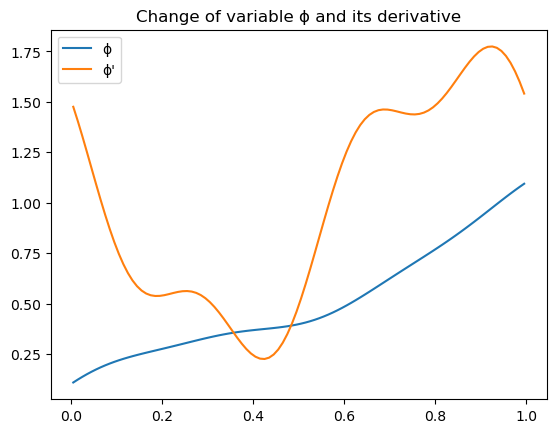

In [26]:
plt.title("Change of variable ϕ and its derivative")
X,dx = make_domain1(100)
plt.plot(X,ϕ,label="ϕ")
plt.plot(X,dϕ,label="ϕ'")
plt.legend();

We now define the modified coefficients and solution, associated to the one-dimensional acoustic change of variables. First as functions.

<!---
def tq_exact(x,*args,**kwargs): return q_exact(ϕ(x),*args,**kwargs)
def tp_exact(x,*args,**kwargs): return p_exact(ϕ(x),*args,**kwargs)
--->

In [27]:
# One dimensional Acoustic change of variables
def tq1a(q,ϕ,dϕ): return q(ϕ) 
def tp1a(p,ϕ,dϕ): return p(ϕ)*dϕ
def tρ1a(ρ,ϕ,dϕ): return ρ(ϕ)*dϕ
def tD1a(D,ϕ,dϕ): return D(ϕ)/dϕ

Now the same, but as numerical arrays.

In [28]:
# PDE coefficients
tρ = tρ1a(lambda x:ρ,ϕ,dϕ)
tD = tD1a(lambda x:D,ϕ,dϕ)

# Time step and total time
dt_max = CFL1a(tρ,tD,dx)
dt = 0.4*dt_max # Will be admissible for all orders
niter = 200
T = niter*dt

# PDE initial condition and solution
def tq_exact(t): return tq1a(lambda x:q_exact(t,x),ϕ,dϕ)
def tp_exact(t): return tp1a(lambda x:p_exact(t,x),ϕ,dϕ)
tq0 = tq_exact(0)
tp0 = tp_exact(0)
tq1_exact = tq_exact(T)
tp1_exact = tp_exact(T)

# Hamiltonian
order_x = 2; order_t = 2
tWaveH = Hamiltonian1a(tρ,tD,X,dx,order=order_x)

Let us run the symplectic Verlet scheme, and compare the solutions. 

In [29]:
tq1,tp1 = tWaveH.Verlet_p(tq0,tp0,dt,niter)

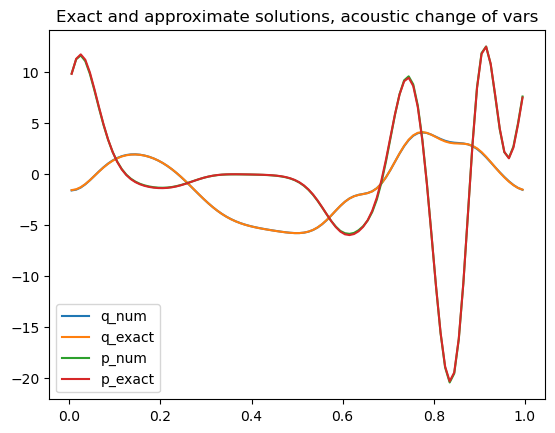

In [30]:
plt.title("Exact and approximate solutions, acoustic change of vars")
plt.plot(X,tq1,label='q_num')
plt.plot(X,tq1_exact,label='q_exact')
plt.plot(X,tp1/(2*π),label='p_num')
plt.plot(X,tp1_exact/(2*π),label='p_exact')
plt.legend();

As before, we test the numerical schemes of various orders systematically.
Fourth order is approximately $45\times$ more accurate than second order (in space and time).

In [31]:
tq1_norm = norm(tq1_exact,np.inf)
tp1_norm = norm(tp1_exact,np.inf)
print(f"Parameters {dx=}, {dt=}, {niter=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian1a(tρ,tD,X,dx,order=order_x)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        tq1,tp1 = WaveH.Sympl_p(tq0,tp0,dt,niter=niter,order=order_t)
        H_num = WaveH.H_p(tq1,tp1,dt,order=order_t)
        H_exact = WaveH.H_p(tq0,tp0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(tq1-tq1_exact,np.inf)/tq1_norm
        p1_relerr = norm(tp1-tp1_exact,np.inf)/tp1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.01, dt=0.0009025984923544046, niter=200.

Parameters order_x=2, order_t=1
H_relerr=-3.9e-16, q1_relerr=0.01, p1_relerr=0.015
Parameters order_x=2, order_t=2


H_relerr=1.7e-15, q1_relerr=0.013, p1_relerr=0.01
Parameters order_x=2, order_t=4


H_relerr=7.2e-15, q1_relerr=0.013, p1_relerr=0.01
Parameters order_x=4, order_t=1
H_relerr=1.3e-16, q1_relerr=0.0045, p1_relerr=0.0049
Parameters order_x=4, order_t=2
H_relerr=2.6e-16, q1_relerr=0.00024, p1_relerr=0.00044
Parameters order_x=4, order_t=4


H_relerr=-2.2e-15, q1_relerr=0.00028, p1_relerr=0.00044


### 1.5 Elastic change of variables

The Hamiltonian of the elastic wave equation, slightly generalized to account for possible anisotropies, reads
\begin{align*}
    H(q,p) &= \int_X |p|^2_M + |\ve|^2_C, &
    \ve = \frac 1 2 (\Diff q + \Diff q^\top) - S q,
\end{align*}
where we denoted:
- $X$ a $d$-dimensional domain, with e.g. periodic boundary conditions for simplicity.
- $M$ a field of symmetric positive definite matrices. In default Cartesian coordinates one has $M = \Id/\rho$ where $\rho$ is the material density.
- $C$ is the Hooke elasticity tensor, which can be regarded as a positive quadratic form over the space $\cS_d$ of symmetric matrices. 
- $\ve$ is the strain tensor.
- $S$ is, at each point of the domain, a linear mapping from $\bR^d$ to the set of symmetric matrices $\cS_d$. In default Cartesian coordinates one has $S = 0$. 

Let $\vp$ be a diffeomorphism of $X$, with positive orientation, and let $\Phi := \Diff \phi$ and $J := \det \Phi$ be the Jacobian matrix and determinant. Define the change of coordinates $A^{-1} q := \Phi^\top q \circ \vp$. 

Note that the presence of the transposed Jacobian $\Phi^\top$ in the latter formula means that $q$ is *dual* to an infinitesimal displacement, which may sound peculiar. The usual interpretation as a displacement is recovered if $M = \Id/\rho$, i.e. when the ambiant space is equipped with the Euclidean metric rather than a general metric.

Then, based on the abstract formulation exposed in the previous section, we find that Hamilton's ODEs are invariant under the following change of coordinates:
\begin{align*}
    \tilde q &= \Phi^\top \ q \circ \vp, &
    \tilde p &= \Phi^{-1} \ p \circ \vp \ J, &
    \tilde M &= \Phi^\top \ M\circ \vp \ \Phi / J, &
    \tilde \ve &= \Phi^\top \ \ve \circ \vp \ \Phi.
\end{align*}
Denoting $\Psi := \Phi^{-1}$ we also have in coordinates 
\begin{align*}
    \tilde C_{ijkl} &:= \sum_{i'j'k'l'} C_{i'j'k'l'} \circ \vp \ \Psi^{i'}_i \Psi^{j'}_j \Psi^{k'}_k \Psi^{l'}_l \ J,&
    \tilde S_{ij}^k &= \sum_{i'j'} \Phi^{i}_{i'} \Phi^{j}_{j'} \ S^{i'j'}_{k'}\circ \vp \ \Psi_k^{k'} 
    {+} \sum_{k'} \partial^{ij}\phi_{k'} \Psi_k^{k'}.
\end{align*}
The validity of these transformations is numerically assessed in [3.2 Change of variables for the elastic wave equation](#3.2-Change-of-variables).

**One dimensional case.**
The Jacobian derivative has shape $1 \times 1$, hence $\Phi = J = \vp'$, and thus the change of variables
\begin{align*}
    \tilde q &= \vp' q \circ \vp, &
    \tilde p &= p \circ \vp, &
    \tilde M &= \vp' M\circ \vp, &
    \tilde C &= (\vp')^{-3} C\circ \vp, &
    \tilde S &= (\vp')^2 S\circ \vp + \vp''/\vp'.
\end{align*}

We numerically validate our numerical scheme, with non-constant coefficients, using the previous exact solution and some arbitrary but smooth change of variables.

<!---
In addition, we can set $\tilde \rho = 1/\tilde M = 1/ (\vp' M\circ \vp) = \rho \circ \vp / \vp'$ (note that $\rho$ is not properly speaking a density here).
--->

In [32]:
def deriv2(ϕ,x): # Compute derivative via automatic differentiation
    """Returns value, derivative, second order derivative, of univariate function"""
    x_ad = ad.Dense2.identity(constant=x,shape_free=tuple())
    ϕ_ad = ϕ(x_ad)
    return ϕ_ad.value, ϕ_ad.gradient(0), ϕ(x_ad).hessian(0,0)

ϕ,dϕ,d2ϕ = deriv2(ϕ_fun,X)

In [33]:
# One dimensional Elastic change of variables
def tq1e(q,ϕ,dϕ): return q(ϕ)*dϕ
def tp1e(p,ϕ,dϕ): return p(ϕ)
def tM1e(M,ϕ,dϕ): return M(ϕ)*dϕ
def tC1e(C,ϕ,dϕ): return C(ϕ)*dϕ**-3
def tS1e(S,ϕ,dϕ,d2ϕ): return S(ϕ)*dϕ**2 + d2ϕ/dϕ

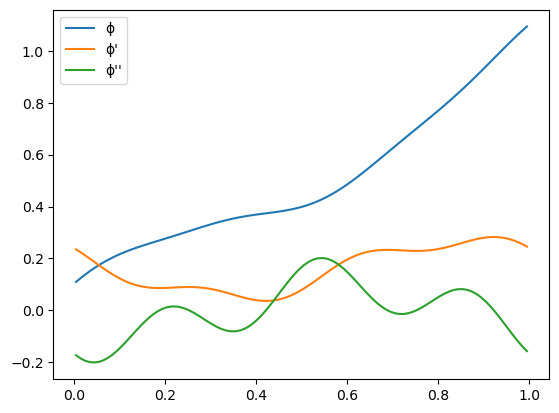

In [34]:
plt.plot(X,ϕ,label="ϕ")
plt.plot(X,dϕ/(2*π),label="ϕ'")
plt.plot(X,d2ϕ/(2*π)**2,label="ϕ''")
plt.legend();

In one dimension, the acoustic and the elastic Hamiltonians are equivalent, up to the following (physically inhomogeneous) substitutions : $\rho = 1/M$, $D = C$.

In [35]:
M=1/ρ
C=D
def Hamiltonian1e(M,C,*args,**kwargs):
    """
    Hamiltonian of the one dimensional elastic wave equation.
    See Hamiltonian1a for args, kwargs.
    """
    return Hamiltonian1a(1/M,C,*args,**kwargs)
def ExactSol1e(M,C,*args,**kwargs):
    """
    Exact solution of the one dimensional elastic wave equation.
    SeeExactSol1a for args, kwargs.
    """
    return ExactSol1a(1/M,C,*args,**kwargs)
def CFL1e(M,C,*args,**kwargs):
    """
    CFL condition for the one dimensional elastic wave equation.
    See CFL1a for args, kwargs.
    """
    return CFL1a(1/M,C,*args,**kwargs)

Now let us compare the exact and numerical solutions.

In [36]:
# PDE coefficients
tM = tM1e(lambda x:M,ϕ,dϕ)
tC = tC1e(lambda x:C,ϕ,dϕ)
tS = tS1e(lambda x:0,ϕ,dϕ,d2ϕ)

# Time step and total time
dt_max = CFL1e(tM,tC,dx)
dt = 0.6*dt_max
niter = 200
T = niter*dt

# PDE initial condition and solution
q_exact,p_exact = ExactSol1e(M,C,qm0,qp0)
def tq_exact(t): return tq1e(lambda x:q_exact(t,x),ϕ,dϕ)
def tp_exact(t): return tp1e(lambda x:p_exact(t,x),ϕ,dϕ)
tq0 = tq_exact(0)
tp0 = tp_exact(0)
tq1_exact = tq_exact(T)
tp1_exact = tp_exact(T)

# Hamiltonian
order_x = 2; order_t = 2
tWaveH = Hamiltonian1e(tM,tC,X,dx,order=order_x,S=tS)

Let us check that our change of variables is correct. The duality bracket, kinetic energy, potential energy, and their sum the Hamiltonian must be conserved by the transformation (note that this is unrelated to the Hamiltonian conservation along the evolution).

In [37]:
WaveH = Hamiltonian1e(M,C,X,dx,order=order_x,S=0.)
q0 = q_exact(0,X)
p0 = p_exact(0,X)

print(f"Duality bracket conservation : {np.sum(p0*q0)=}, {np.sum(tp0*tq0)=}")
print(f"Kinetic energy conservation : {np.sum(tp0**2*tM)=}, {np.sum(p0**2*M)=}")    
print(f"Hamiltonian conservation : {tWaveH.H(tq0,tp0)=}, {WaveH.H(q0,p0)=}")

# We differentiate numerically here, because
dq0,dtq0 = [(np.roll(a,-1)-np.roll(a,1))/(2*dx) for a in (q0,tq0)]
print(f"Potential energy conservation : {np.sum(dq0**2 * C)=}, {np.sum((dtq0-tS*tq0)**2 * tC)=}")

Duality bracket conservation : np.sum(p0*q0)=-6.359357485052897e-13, np.sum(tp0*tq0)=1.2505552149377763e-12
Kinetic energy conservation : np.sum(tp0**2*tM)=111033.04951225534, np.sum(p0**2*M)=111033.04951225528
Hamiltonian conservation : tWaveH.H(tq0,tp0)=111447.39661469353, WaveH.H(q0,p0)=110849.57373439583
Potential energy conservation : np.sum(dq0**2 * C)=109574.40728233082, np.sum((dtq0-tS*tq0)**2 * tC)=108872.1033565989


Since we use a symplectic scheme, the discrete perturbed Hamiltonian is conserved along the evolution up to machine precision.

In [38]:
tq1,tp1 = tWaveH.Sympl_p(tq0,tp0,dt,niter,order_t)

In [39]:
tWaveH.H_p(tq0,tp0,dt,order=order_t),tWaveH.H_p(tq1,tp1,dt,order=order_t)

(111437.26542555663, 111437.26542555666)

The numerical error is a bit larger than in the previous case, likely because the PDE coefficients involve the terms $\phi''$ and $\phi'^{-3}$ which are large and vary quickly over the domain.

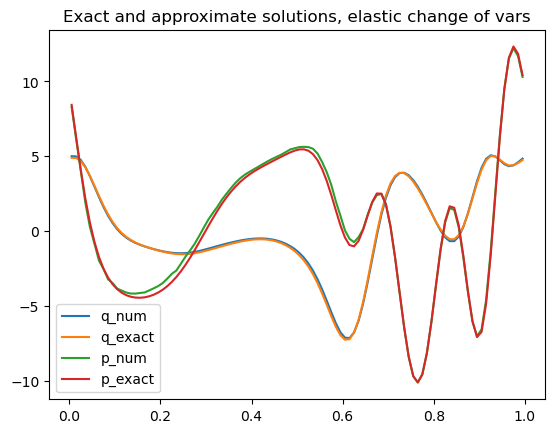

In [40]:
plt.title("Exact and approximate solutions, elastic change of vars")
plt.plot(X,tq1,label='q_num')
plt.plot(X,tq1_exact,label='q_exact')
plt.plot(X,tp1/(2*π),label='p_num')
plt.plot(X,tp1_exact/(2*π),label='p_exact')
plt.legend();

The fourth order scheme (in time and space) reduces error by approximately $40\times$ w.r.t the second order scheme.

In [41]:
tq1_norm = norm(tq1_exact,np.inf)
tp1_norm = norm(tp1_exact,np.inf)
print(f"Parameters {dx=}, {dt=}, {niter=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian1e(tM,tC,X,dx,order=order_x,S=tS)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        tq1,tp1 = WaveH.Sympl_p(tq0,tp0,dt,niter=niter,order=order_t)
        H_num = WaveH.H_p(tq1,tp1,dt,order=order_t)
        H_exact = WaveH.H_p(tq0,tp0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(tq1-tq1_exact,np.inf)/tq1_norm
        p1_relerr = norm(tp1-tp1_exact,np.inf)/tp1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.01, dt=0.001353897738531607, niter=200.

Parameters order_x=2, order_t=1
H_relerr=2.6e-16, q1_relerr=0.039, p1_relerr=0.047
Parameters order_x=2, order_t=2


H_relerr=2.6e-16, q1_relerr=0.038, p1_relerr=0.055
Parameters order_x=2, order_t=4


H_relerr=-1.6e-10, q1_relerr=0.038, p1_relerr=0.055
Parameters order_x=4, order_t=1
H_relerr=-5.2e-16, q1_relerr=0.0073, p1_relerr=0.0077
Parameters order_x=4, order_t=2
H_relerr=6.6e-16, q1_relerr=0.00071, p1_relerr=0.0015
Parameters order_x=4, order_t=4


H_relerr=-7.8e-14, q1_relerr=0.00063, p1_relerr=0.0013


### 1.6 Damping

The computational domain for acoustic and elastic wave propagation is often only a small part of the full physical domain.
For this reason, one needs to introduce boundary conditions that mimick an infinite domain. 

The state of the art methods are referred to as "perfectly matched layers" (PML). However, their implementation is non-trivial in our case since the geometry of the PDE varies over the domain, is anisotropic, and in the elastic case since the different propagation modes have distinct and non-convex anisotropic speed profiles. 

For this reason, we content ourselves with a simpler approach, which is to introduce a damping layer around the domain. This layer is intended to absorb the kinetic energy, over possibly a few wavelengths, without introducing too much reflection toward the interior of the domain.
It is implemented as a linear term in the momentum evolution PDE:
\begin{align*}
    \dot q &= \partial_p H, &
    \dot p &= -\partial_q H - \omega p.
\end{align*}

**Time discretization.**
We alternate time steps for the Hamiltonian ODE $\dot q = \partial_p H$, $\dot p = -\partial_q H$, with time steps for the damping ODE $\dot q = 0$, $\dot p = -\omega p$. 

A timestep $\delta$ for the damping ODE is implemented with the exact scheme
\begin{align*}
    q' &= q, &
    p' &= \exp(-\omega \delta) p.
\end{align*}
However, since the two ODEs do not commute, the overall alternating scheme is only second order accurate in time with the damped equation. 

In [42]:
def Damp_p(p,ω,dt): return np.exp(-ω*dt)*p

**Discrete Hamiltonian reduction with the Verlet scheme.**
Recall that discrete perturbed Hamiltonian conserved by the Verlet scheme reads 
$$
    2 H_V(q,p) = p^\top A p + q^\top (B-\tfrac 1 4 \delta^2 B A B)q.
$$
The matrix $A$, associated to the kinetic energy, is diagonal with positive entries. 

On the other hand, we can express the damping step as $p' = \cD p$ where $\cD$ is diagonal with entries in $[0,1]$ since they are negative exponentials. It follows that $(\cD p)^\top A (\cD p) \leq p^\top A p$. 
Hence the Verlet discrete Hamiltonian decreases along the evolution, since it is preserved by the symplectic steps, and decreased by the damping steps.

In contrast, the Ruth4 perturbed Hamiltonian has a more complex structure, see above. In that case the discrete perturbed kinetic energy involves the matrix $B$ which does not commute with $\cD$. Therefore no such decreasing Hamiltonian value guarantee holds. 

**Construction of damping parameter.**
Suppose that we want to absorb oscillating waves, with a given wavelength $l$ (or smaller), and a given velocity $c$. Denote by $k = 2 \pi/l$ the wave number. Then heuristically, one would choose a damping parameter $\omega$ (inverse of a time) with the following properties:
- (Maximum damping parameter) The maximal value is $\omega_{\max} = k c/\alpha = 2\pi c/(l \alpha)$ where $\alpha \gtrsim 1$, so that amplitude is approximately multiplied by $\exp(-2 \pi / \alpha)$ over the wavelength $l$. This is a substantial decrease, but not too sharp  either so as to avoid reflections.
- (Transition ramp) Damping varies from $0$ to $\omega_{\max}$ over a few wavelengths. Sharp or discontinuous transitions may induce reflections. 
- (Boundary layer width) The boundary layer should be a few wavelengths too.

Heuristically, we can aim for an amplitude reduction by $r \approx 500 \approx \exp(2 \pi)$, achieved over $\alpha \log(r)/(2 \pi) \approx \alpha $ wavelengths. 
Note that the damping effect of the transition ramp should be on average half as strong due to the mean value $\omega_{\max}/2$ of the damping parameter $\omega$ in that region.

Finally, we note that there is also potential energy, which is converted into kinetic energy over the course of one wavelength approximately. For this reason, we must double the thickness computed above. 
However, the damping region length should be counted twice, due to the periodic boundary conditions, which compensates.

<!---
For concreteness, say e.g that $\omega$ varies over $4l$, and that $\omega_\max = \pi c/l$.
--->

In [43]:
np.exp(2*π)

535.4916555247646

In [44]:
def bump(x,r,δ):
    """A bump over the interval [-r,r], with a transition over [r-δ,r+δ]"""
    # Primitives of (1-x^2)^k : x - x**3/3, x - (2*x**3)/3 + x**5/5, x - x**3 + (3*x**5)/5 - x**7/7
    def p(x): return x - (2*x**3)/3 + x**5/5
    def f(x): return np.where(x<=-1,-1,np.where(x>=1,1,p(x)/p(1)))
    return 0.5+0.5*f((r-np.abs(x))/δ)

def bump_per(x,*args,**kwargs):
    """
    1-periodic bump function
    args,kwargs : see bump(x,r,δ) function
    """
    return bump((x+0.5)%1-0.5,*args,**kwargs)

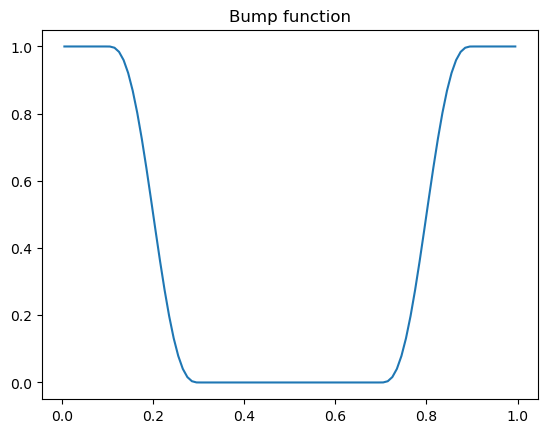

In [45]:
plt.title(f"Bump function")
plt.plot(X,bump_per(X,0.2,0.1));

In [46]:
def damping(X,ρ,D,k,α,r=500):
    """
    X : domain
    ρ,D : acoustic equation parameters (expecting constants)
    k : wave number
    α : sharpness of transition (sharp : α=1, non-sharp : α >> 1) 
    r : desired amplitude reduction
    """
    c = np.sqrt(D/ρ) # Wave speed
    ωmax = k*c/α # Maximum damping amplitude
    L = α*np.log(r)/k # Total equivalent thickness of boundary layer
    return ωmax * bump_per(X,L,L/2)

In order to illustrate the damping effect, we construct an exact solution with a smaller effective support, and going only to the right.

In [47]:
k = 8*2*π
def qm1(x): return 0.*x # Multiplication by x needed for autodiff
def qp1(x): return np.cos(k*x) * np.exp(-4*np.cos(2*π*x))
q_exact,p_exact = ExactSol1a(ρ,D,qm1,qp1)

q0 = q_exact(0,X)
p0 = p_exact(0,X)
ω_damp = damping(X,ρ,D,k,α=1.5)

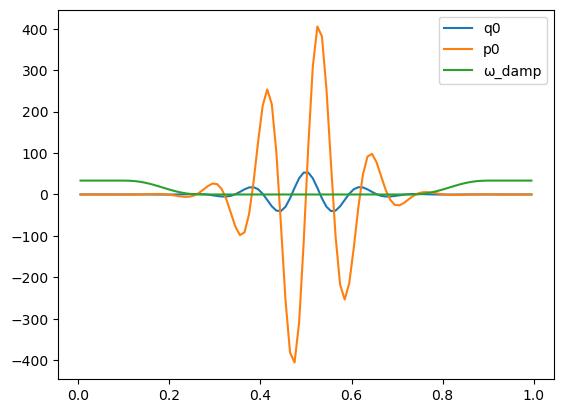

In [48]:
plt.plot(X,q0,label="q0")
plt.plot(X,p0/(2*π),label="p0")
plt.plot(X,ω_damp,label="ω_damp")
plt.legend();

In [49]:
order_x=2; order_t=2
WaveH = Hamiltonian1a(ρ,D,X,dx,order=order_x)
dt_max = CFL1a(ρ,D,dx)

Recall that the domain is $[0,1]$ with periodic boundary conditions. We run the wave propagation during time $T=0.3/c$, and observe that :
- The damped and undamped waves are almost identical before the damping region.
- The damped wave decreases sharply in amplitude in the damping region.
- The damped wave features a small reflected wave on the left. This is an undesirable artifact of the damping method, which motivates more advanced techniques such as PML.

In [50]:
c=np.sqrt(D/ρ); T = 0.3/c
niter = np.round(1.5*T/dt_max).astype(int)
dt = T/niter

q1_nodamp,p1_nodamp = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

q1_damp,p1_damp = q0,p0
for i in range(niter):
    q1_damp,p1_damp = WaveH.Sympl_p(q1_damp,p1_damp,dt,order=order_t) # Symplectic step
    p1_damp *= np.exp(-dt*ω_damp) # Damping step

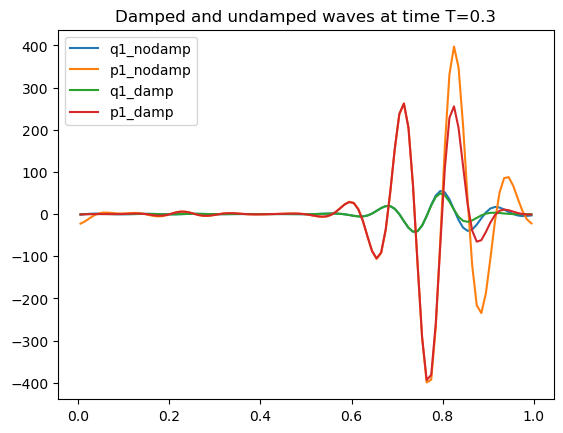

In [51]:
plt.title(f"Damped and undamped waves at time {T=}")
plt.plot(X,q1_nodamp,label="q1_nodamp")
plt.plot(X,p1_nodamp/(2*π),label="p1_nodamp")
plt.plot(X,q1_damp,label="q1_damp")
plt.plot(X,p1_damp/(2*π),label="p1_damp")
plt.legend();

At time $T = 1/c$ all the wave has gone through the boundary layer.

In [52]:
T = 1./c
niter = np.round(1.5*T/dt_max).astype(int)
dt = T/niter

q1_nodamp,p1_nodamp = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

q1_damp,p1_damp = q0,p0
H_values = []
for i in range(niter):
    H_values.append(WaveH.H_p(q1_damp,p1_damp,dt,order=order_t)) # Save the total energy
    q1_damp,p1_damp = WaveH.Sympl_p(q1_damp,p1_damp,dt,order=order_t) # Symplectic step
    p1_damp *= np.exp(-dt*ω_damp) # Damping step

We see that the Hamiltonian:
- Is always non-increasing. This is guaranteed by construction for the the Verlet scheme.
- Is constant when the wave travels in an undamped region, and strictly decreasing when it goes through the damped region.
- The first decreasing interval is due to the main wave going through the damping region, and the second one to the reflected wave going through the damping region (in the opposite direction after it travelled through the domain in reverse).

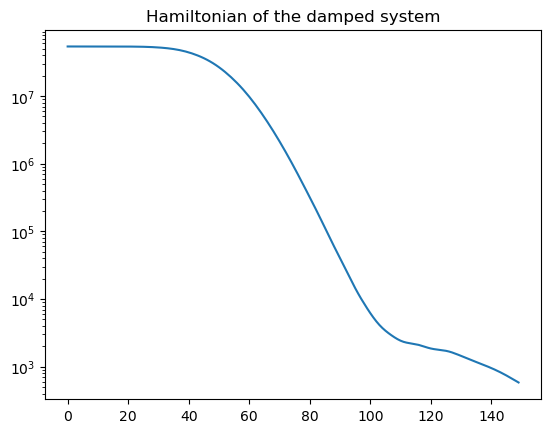

In [53]:
plt.title("Hamiltonian of the damped system")
plt.semilogy(ad.array(H_values));

In [54]:
assert np.all(H_values[1:]<=H_values[:-1]) # The Hamiltonian of the Verlet scheme is always decreasing.

The energy (Hamiltonian) is a quadratic function of the amplitude. We were heuristically expecting a decrease by a factor $r^2$ with $r=500$, but find a slightly less strong reduction. The difference is likely due to the energy remaining in the reflected wave.

In [55]:
np.sqrt(H_values[1]/H_values[-1])

304.2430839030629

The Hamiltonian class allows to introduce damping steps along the time integration, as follows.

In [56]:
WaveH.damp_p = ω_damp # Damping factor for p variable.
q2_damp,p2_damp = WaveH.Sympl_p(q0,p0,dt,order=order_t,niter=niter)
# Damping is only inserted in between time steps, hence we do the last one by hand
p2_damp *= np.exp(-dt*ω_damp)
# Identical up to machine precision... although errors quickly accumulate in single precision
assert allclose(q1_damp,q2_damp,atol=1e-8 if xp is np else 1e-4) 
assert allclose(p1_damp,p2_damp,atol=1e-8 if xp is np else 1e-2)

### 1.7 (Symplectic) Adjoint operators

**The symplectic form.**
Let $E$ be a (topological) vector space, and let $E^*$ denote its dual. The canonical symplectic form is the antisymmetric bilinear form defined as
\begin{align*}
    \Omega & : (E \times E^*)^2 \to \bR, &
    \Omega((q_0,p_0), (q_1,p_1)) := \<q_0,p_1\> - \<p_0,q_1\>,
\end{align*}
where $\<\cdot,\cdot\> : E \times E^* \to \bR$ denotes the duality bracket.

In particular, the symplectic form over $\bR^N$ is represented by the $2 N \times 2 N$ anti-symmetric matrix
$$
    \Omega = 
    \begin{pmatrix}
    & \Id \\
    -\Id &
    \end{pmatrix}.
$$
The symplectic adjoint of an operator $L$ can be expressed in terms of the usual ajdoint as $\Omega^\top L^\top \Omega$. Note that $\Omega^\top = -\Omega = \Omega^{-1}$.

In [57]:
def Ω(q0,p0,q1,p1): 
    """The canonical symplectif form."""
    return np.sum(q0*p1 - p0*q1)

**Quadratic Hamiltonian systems.**
Hamilton's ODEs associated to an arbitrary non-linear Hamiltonian preserve the symplectic form in a suitable sense.
The formalism is however made simpler when the Hamiltonian is quadratic, meaning that the the evolution law is linear, and we thus focus on this case. We later specialize to *separable* quadratic Hamiltonians, an even simpler setting which encompasses the acoustic and elastic wave equations.

Assuming a quadratic Hamiltonian, we thus have 
\begin{align*}
    \dot q & = \partial_p H(q,p) = H_{pq} q + H_{pp} p, &
    \dot p & = - \partial_q H(q,p) = -H_{qq} q - H_{qp} p,
\end{align*}
where $H_{qq} = \partial_{qq} H$, $H_{qp} = \partial_{qp} H$, etc, are linear operators. Note that $H_{qq}$ and $H_{pp}$ are symmetric, and that $H_{qp} = H_{pq}^\top$. 

Given two solutions $(q_0,p_0)$ and $(q_1,p_1)$ of these ODEs, we thus have 
\begin{align*}
    \Omega( (\dot q_0,\dot p_0), (q_1,p_1) ) &= \<\dot q_0,p_1\> - \<\dot p_0,q_1\> \\
    &= \< H_{pq} q_0 + H_{pp} p_0,p_1\> - \< - H_{qq} q_0 - H_{qp} p_0,q_1\> \\ 
    &= \<q_0, H_{qp} p_1 + H_{qq} q_1\> + \<p_0, + H_{pp} p_1 + H_{p q} q_1\> \\
    &= - \<q_0, \dot p_1\> + \<p_0,\dot q_1\> \\
    &= - \Omega( (q_0,p_0), (\dot q_1,\dot p_1) ).
\end{align*}
Said otherwise, Hamilton's ODE defines a linear operator, whose symplectic adjoint is the evolution in reverse time.

**Separable case and symplectic timestep.** If $2 H(q,p) = p^\top A p + q^\top B q$ is a separable quadratic Hamiltonian, where $A$ and $B$ are linear symmetric, then $\partial_{pp} H = A$, $\partial_{qq} H = B$, and $\partial_{pq} H = 0$. 

The symplectic adjoints of the timesteps $p' = p - \delta B q$ and $q' = q+\delta A p$, are the same timesteps with opposite $\delta$
\begin{align*}
\<q_0',p_1\> - \<p_0,q_1\> = \<q_0+\delta A p_0,p_1\> - \<p_0,q_1\> = \<q_0, p_1\> - \<p_0,q_1-\delta A p_1\>,\\
\<q_0,p_1\> - \<p_0',q_1\> = \<q_0,p_1\> - \<p_0-\delta B q_0,q_1\> = \<q_0, p_1+\delta B q_1\> - \<p_0,q_1\>.
\end{align*}

The Verlet and Ruth4 schemes are compositions of such timesteps. Their adjoint are the same timesteps, in reversed order and with opposite $\delta$.
(Non-separable Hamiltonians lead to additional complexities, featuring implicit time steps.)

**Damping.**
The adjoint of the damping operation, considered in the previous subsection, is a reduction of amplitude : 
$$
\<q_0,p_1\> - \<\cD p_0,q_1\> = \<q_0,p_1\> - \<p_0, \cD q_1\>.
$$
Recall that $C$ is a diagonal matrix with entries $\exp(-\omega \delta)$.

For computational efficiency, one often merges two updates and one damping of the impulsion, as follows:
\begin{align*}
    p' &= p-\delta B q, &
    p'' &= \cD p', &
    p''' &= p''-\eta B q = \cD p - (\delta \cD + \eta) B q.
\end{align*}
The adjoint of this operation is the following mixed update:
$$
    \<q_0,p_1\> - \<p_0''',q_1\> 
    = \<q_0,p_1\> - \<\cD p_0 - (\delta \cD + \eta) B q_0,q_1\> 
    = \<q_0,p_1+ B (\delta \cD+\eta) q_1\> - \<p_0,\cD q_1\>.
$$


In [58]:
# Using random values for everything, to test adjointness (no CLF needed)
np.random.seed(42); N = len(X)
q0,p0,q1,p1,ρ,D,ω_damp = xp.random.rand(7,N); δ=0.8
WaveH = Hamiltonian1a(ρ,D,X,dx)

We first check adjointness for the elementary timesteps.

In [59]:
# Checking adjointness for the explicit Euler step q' = q + δAp
assert allclose(Ω(WaveH.Expl_q(q0,p0,δ),p0,q1,p1), Ω(q0,p0,WaveH.Expl_q(q1,p1,-δ),p1))

# Checking adjointness for the explicit Euler step p' = p - δBq
assert allclose(Ω(q0,WaveH.Expl_p(q0,p0,δ),q1,p1), Ω(q0,p0,q1,WaveH.Expl_p(q1,p1,-δ)))

# Checking the adjointness for the damping step p' = exp(-ω δ) p
assert allclose(Ω(q0,Damp_p(p0,ω_damp,δ),q1,p1), Ω(q0,p0,Damp_p(q1,ω_damp,δ),p1))

We next turn to composite operations, starting with the symplectic `Euler_p` scheme, which successively updates $p$ then $q$.
As discussed above, the ordering of the updates must be reversed, leading to the `Euler_q` scheme, which successively updates $q$ then $p$.

In [60]:
# Checking adjointness for the Verlet scheme
assert allclose(Ω(*WaveH.Euler_p(q0,p0,δ),q1,p1),Ω(q0,p0,*WaveH.Euler_q(q1,p1,-δ)))

The Verlet_p and Ruth4_p schemes use a reversible ordering of updates, $(p,q,p)$ and $(p,q,p,q,p,q,p)$ respectively, and the sequence of sub-timesteps is also reversible. Therefore it suffices to use the opposite timestep parameter $\delta$.

In [61]:
# Checking adjointness for the Verlet scheme
assert allclose(Ω(*WaveH.Verlet_p(q0,p0,δ),q1,p1),Ω(q0,p0,*WaveH.Verlet_p(q1,p1,-δ)))

# Checking adjointness for the Ruth4 scheme
assert allclose(Ω(*WaveH.Ruth4_p(q0,p0,δ),q1,p1),Ω(q0,p0,*WaveH.Ruth4_p(q1,p1,-δ)))

Finally, optional damping steps are included in between time steps.

In [62]:
WaveH_p = copy.copy(WaveH); WaveH_p.damp_p =  ω_damp
WaveH_q = copy.copy(WaveH); WaveH_q.damp_q = -ω_damp

assert allclose(Ω(*WaveH_p.Verlet_p(q0,p0,δ,niter=2),q1,p1),Ω(q0,p0,*WaveH_q.Verlet_p(q1,p1,-δ,niter=2)))
assert allclose(Ω(*WaveH_p.Ruth4_p(q0,p0,δ,niter=2),q1,p1),Ω(q0,p0,*WaveH_q.Ruth4_p(q1,p1,-δ,niter=2)))

### 1.8 Automatic differentiation of the Hamiltonian

In this brief section, we consider the differentiation of a Hamiltonian w.r.t the medium parameters. We focus on the acoustic wave equation for simplicity. See below for more discussion of the finite difference scheme.

Because of the incompatibilities between different AD types, we need to extract one AD channel of the result.

In [63]:
def Hamiltonian_ad(ρ,D,X,dx):
    """Acoustic wave Hamiltonian with AD capabilities."""
    iρ=1/ρ
    λ,e = Selling.Decomposition(D) # See below
    def Hq(q,ad_channel=lambda x:x):
        dq = fd.DiffEll(q,e,dx,padding=None)
        return 0.5 * ad_channel(λ) * dq**2
    def Hp(p,ad_channel=lambda x:x):
        return 0.5 * ad_channel(iρ) * p**2
    H = QuadraticHamiltonian(Hq,Hp)
    H.set_spmat(xp.zeros_like(X)) # Replaces quadratic functions with sparse matrices
    return H

We can choose a density and/or a metric featuring a (first order dense) AD part.

In [64]:
np.random.seed(42)
X,dx = make_domain1(10)
nX = len(X)
def rand(*args): return xp.asarray(np.random.rand(*args))
ρ = rand(nX) # Standard density
#ρ = ad.Dense.identity(constant=rand(nX),shape_free=tuple()) # AD density
#D = rand(1,1,nX) # Standard metric
D = ad.Dense.identity(constant=rand(1,1,nX),shape_free=tuple()) # AD metric
H0 = Hamiltonian_ad(ρ,D,X,dx)

The symplectic scheme automatically computes a first order expansion of the solution w.r.t the perturbation of the Hamiltonian coefficients.

In [65]:
# q0 and p0 do not contain any ad info, but need to be of the correct type
q0 = ad.Dense.denseAD(rand(nX))
p0 = ad.Dense.denseAD(rand(nX))
dt = 1
H0.damp_p = rand(nX)
H0.damp_q = rand(nX)

H0.Verlet_p(q0,p0,dt,niter=2)

(denseAD(array([ 6.89178302e+03, -2.89096384e+03,  2.58463393e+03,  8.76879089e+01,
        -7.25793423e+03,  3.54818530e+04, -2.40849374e+05,  8.26776543e+03,
         2.43189123e+03, -2.50577351e+03]),
 array([[   42399.69120447],
        [  -11059.32013992],
        [    6783.74753728],
        [    2118.43427022],
        [  -71427.83011464],
        [  279574.77501337],
        [-1545362.11742219],
        [   46892.88862118],
        [   14043.86534039],
        [  -18849.50487212]])),
 denseAD(array([-3.12914004e+05,  4.86210642e+05, -3.10049265e+05, -7.11296980e+03,
         4.61496153e+05, -3.75350776e+06,  8.51774292e+06, -5.29535949e+06,
         5.17820177e+04,  1.60742021e+05]),
 array([[ -2744344.67944588],
        [  2880147.2328148 ],
        [ -1319503.28683461],
        [  -844042.4365942 ],
        [  6422764.64504555],
        [-41362946.59532595],
        [ 81430162.93978725],
        [-46492123.43247995],
        [   244359.10092233],
        [  1775523.35353606]]

In practice, for underground reconstruction, reverse mode AD is usually more appropriate than the forward AD illustrated above. 

Fortunately, in this case, reverse mode AD is equivalent to forward mode AD in reverse time. 

In [66]:
q1 = ad.Dense.denseAD(rand(nX))
p1 = ad.Dense.denseAD(rand(nX))
H1 = copy.copy(H0)
H1.damp_p = -H0.damp_q
H1.damp_q = -H0.damp_p

res0 = Ω(*H0.Verlet_p(q0,p0,dt,niter=2),q1,p1)
res1 = Ω(q0,p0,*H1.Verlet_p(q1,p1,-dt,niter=2))

assert allclose(res0.value,res1.value) and allclose(res0.coef,res1.coef)

## 2. Two dimensional acoustic waves

Let us recall the Hamiltonian of the acoustic wave equation : 
$$
    2 H_a(q,p) = \int_X \frac {p^2} \rho + |\nabla q|_D^2,
$$
where $\rho>0$ is a density field, and $D \succ 0$ is a field of symmetric positive definite matrices.

**Discretization using the Selling/Voronoi matrix decomposition.**
Similarly to several other notebooks on [divergence form](AnisotropicDiffusion.ipynb) and [non-divergence form](../Notebooks_NonDiv/LinearMonotoneSchemes2D.ipynb) elliptic equations, we compute pointwise [Selling's decomposition](../Notebooks_Algo/TensorSelling.ipynb) of the matrix field : 
$$
    D(x) = \sum_{1 \leq i \leq I} \lambda_i(x) e_i e_i^\top,
$$
with non-negative weights $\lambda_i \geq 0$, offsets with integer coordinates $e_i \in \bZ^d \sm \{0\}$, and with $I = d (d+1)/2$ terms typically. 

In [67]:
ρ = 1
D = Riemann.from_diagonal([3**2, 1]).rotate_by(np.pi/8).m
print(f"Chosen positive definite matrix D=\n{D}.")

Chosen positive definite matrix D=
[[7.82842712 2.82842712]
 [2.82842712 2.17157288]].


The above line constructs the $2\times 2$ matrix $D$ from its eigenvalues and a rotation angle. 

In [68]:
λ,e = Selling.Decomposition(D)
print(f"Selling weights {λ=}.")
print(f"Offsets e=\n{e}.")

Selling weights λ=array([1.51471863, 0.65685425, 3.6862915 ]).
Offsets e=
[[ 1 -2  1]
 [ 1 -1  0]].


Then the potential energy can be approximated with second order accuracy as 
$$
    |\nabla q(x)|_{D(x)}^2 = \sum_{1 \leq i \leq I} 
    \frac{\lambda_i(x)} 2 \Big(\big(\frac{q(x-h e_i)-q(x)} h\big)^2 
    {+} \big(\frac{q(x+h e_i)-q(x)} h\big)^2\Big) + \cO(h^2).
$$
A fourth order accurate scheme can also be obtained, with a similar sum-of-squared differences structure, by a straightforward adaptation of the one-dimensional setting see [1.1 Spatial discretization](#1.1-Spatial-discretization).

In [69]:
def PotentialEnergy_a(q,D,dx,order=2):
    """Acoustic potential energy density (x2)"""
    λ,e = Selling.Decomposition(D) # Coefficients and offsets of Selling's decomposition
    λ = fd.as_field(λ,q.shape,depth=1) # Broadcasting coefficients if necessary
    diff = fd.DiffEll(q,e,dx,order,padding=None) # padding=None means periodic
    return 0.5 * λ*diff**2 # Summation is implicit

In [70]:
def Hamiltonian_a(ρ,D,X,dx,order=2):
    """Discretized Hamiltonian of the acoustic wave equation."""
    Hq = lambda q: PotentialEnergy_a(q,D,dx,order=order) 
    Hp = lambda p: KineticEnergy_a(p,ρ)
    H = QuadraticHamiltonian(Hq,Hp)
    H.set_spmat(xp.zeros_like(X[0])) # Replaces quadratic functions with sparse matrices
    return H

The study of the CFL stability condition is similar to the one dimensional case, see also the notebook on [divergence form](AnisotropicDiffusion.ipynb) anisotropic diffusion. 

The following is a bit conservative, especially for strongly anisotropic $D$. (For a sharper CFL, replace $\Tr(D)$ with $\sum_{1 \leq i \leq I} \lambda_i$, the sum of the coefficients of Selling's decomposition.)

In [71]:
def CFL_a(ρ,D,*args,**kwargs):
    """
    Courant-Friedrichs-Levy stability condition of the acoustic wave scheme. 
    See CFL1a for args and kwargs. 
    """
    return CFL1a(ρ,lp.trace(D),*args,**kwargs) # Conservative estimate.

**Effective construction.** 
Let us construct the discretization grid, and the discretized Hamiltonian.

In [72]:
def make_domain(N,ndim):
    """Returns X, a regular sampling of [0,1]^d with N^d points, and dx the grid scale."""
    aX,dx = xp.linspace(0,1,N,endpoint=False,retstep=True)
    return xp.asarray(xp.meshgrid(*(aX+dx/2,)*ndim,indexing="ij")),dx

In [73]:
X,dx = make_domain(100,2)

In [74]:
order_x=2; order_t=2
WaveH = Hamiltonian_a(ρ,D,X,dx)
dt_max = CFL_a(ρ,D,dx,order_x=order_x,order_t=order_t)

### 2.1 Constant coefficients

In order to validate the scheme we construct a non-trivial explicit solution, with constant coefficients $\rho>0$ and $D\succ 0$ over the domain.

First, let us ignore the boundary conditions. Then 
$$
    q(t,x) := f(\<\kw,x\>-\omega t),
$$
obeys
\begin{align*}
    \diver(D \nabla q) &= |k|^2_D f''(\<\kw,x\>-\omega t), &
    \partial_{tt} q = \omega^2 f''(\<\kw,x\>-\omega t).
\end{align*}
Define the associated impulsion as
$$
    p(t,x) = \rho \dot q = - \rho \omega f'(\<\kw,x\> - \omega t).
$$
If the wavenumber $\kw\in \bR^d$ and the pulsation $\omega$ obey 
$$
|\kw|^2_D = \rho \omega^2,
$$
then $(q,p)$ is a solution of the acoustic wave equation with constant coefficients : $\dot p = \diver(D \nabla u)$, $\dot q = p/\rho$.

**Periodicity.**
Our solution needs to be defined on torus $(\bR/\bZ)^2$, equivalently $[0,1]^2$ with periodic boundary conditions.
This is satisfied provided $f$ is $1$-periodic, and $k \in  \bZ^d$ has integer components.

In [75]:
def ExactSol_a(ρ,D,ks,fs):
    """
    Produce an exact solution for the acoustic wave equation, 
    with constant density ρ and dual metric D.
    - ks : list of wave numbers.
    - fs : list of functions.
    Choose ks with integer coordinates, and fs 1-periodic, to obtain a solution on (R/Z)^2
    """
    vdim = len(D); ks = xp.array(ks)
    ωs = [np.sqrt(lp.dot_VAV(k,D,k)/ρ) for k in ks]
    ks = ks.reshape((-1,vdim)+(1,)*vdim)
    def q(t,x): return sum( f(lp.dot_VV(k,x)-ω*t) for (k,ω,f) in zip(ks,ωs,fs) )
    def p(t,x): return sum( -ρ*ω*deriv(f,lp.dot_VV(k,x)-ω*t) for (k,ω,f) in zip(ks,ωs,fs) )
    return q,p

In [76]:
q_exact,p_exact = ExactSol_a(ρ,D,[
    (1,0),(1,-1),(-2,1) # wavenumbers
],[
    lambda s:0.5*np.cos(6*π*s+1.2), # Some arbitrary 1-periodic function
    lambda s:np.exp(np.cos(4*π*s+4)), 
    lambda s:np.cos(2*π*s+2)])

In [77]:
q0 = q_exact(0,X)
p0 = p_exact(0,X)
print(f"Amplitude of initial position : {norm(q0,np.inf)}, momentum : {norm(p0,np.inf)}")

Amplitude of initial position : 4.195493462488417, momentum : 93.34450988225066


Let us check the $1$-periodicity w.r.t position X.

In [78]:
assert allclose(q_exact(1.4,[X[0]+1,X[1]+2]),q_exact(1.4,X))
assert allclose(p_exact(2.,[X[0]-1,X[1]+3]),p_exact(2.,X),atol=1e-8 if xp is np else 1e-3)

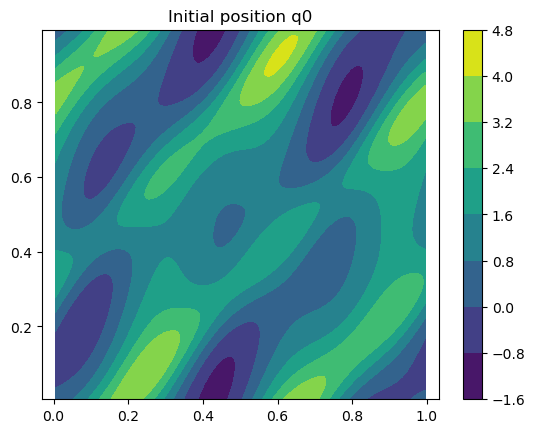

In [79]:
plt.title("Initial position q0")
plt.contourf(*X,q_exact(0,X)) 
plt.colorbar()
plt.axis('equal');

In [80]:
dt = 0.6*dt_max
niter = 100
T = niter*dt
q1_exact = q_exact(T,X); p1_exact = p_exact(T,X)
q1_norm = norm(q1_exact,np.inf); p1_norm = norm(p1_exact,np.inf)

In [81]:
q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

As before, the Verlet Hamiltonian is conserved up to machine precision, and the scheme is second order accurate.

In [82]:
WaveH.H_p(q1,p1,dt,order=2),WaveH.H_p(q0,p0,dt,order=2)

(13279309.546274524, 13279309.546274524)

In [83]:
norm(q1_exact-q1,np.inf)/q1_norm, norm(p1_exact-p1,np.inf)/p1_norm

(0.006708199930284478, 0.016986832391896578)

Let us systematically test the different schemes.
The fourth order scheme (in time and space) is $70\times$ more accurate than the second order scheme.

In [84]:
print(f"Parameters {dx=}, {dt=}, {niter=}, {ρ=}, \n{D=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian_a(ρ,D,X,dx,order=order_x)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)
        H_num = WaveH.H_p(q1,p1,dt,order=order_t)
        H_exact = WaveH.H_p(q0,p0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(q1-q1_exact,np.inf)/q1_norm
        p1_relerr = norm(p1-p1_exact,np.inf)/p1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.01, dt=0.0018973665961010276, niter=100, ρ=1, 
D=array([[7.82842712, 2.82842712],
       [2.82842712, 2.17157288]]).



Parameters order_x=2, order_t=1
H_relerr=1.4e-16, q1_relerr=0.014, p1_relerr=0.038
Parameters order_x=2, order_t=2
H_relerr=0, q1_relerr=0.0067, p1_relerr=0.017
Parameters order_x=2, order_t=4
H_relerr=1.5e-12, q1_relerr=0.0078, p1_relerr=0.02


Parameters order_x=4, order_t=1
H_relerr=0, q1_relerr=0.015, p1_relerr=0.023
Parameters order_x=4, order_t=2


H_relerr=2.8e-16, q1_relerr=0.0012, p1_relerr=0.0026
Parameters order_x=4, order_t=4


H_relerr=2.2e-14, q1_relerr=0.00011, p1_relerr=0.00035


### 2.2 Change of variables

The change of variable formulas for the acoustic wave equation were presented in [1.4 Acoustic change of variables](#1.4-Acoustic-change-of-variables). Let us recall them : 
\begin{align*}
    \tilde q &:= q \circ \vp, &
    \tilde p &:= p \circ \vp\ J, &
    \tilde \rho &:= \rho \circ \vp \ J, &
    \tilde D &:= \Phi^{-1} D \Phi^{-\top} \ J.
\end{align*}
We use a change of variables that is compatible with the torus domain $(\bR/\bZ)^2$, and apply it to the constant coefficient case for which an exact solution is known.

In [85]:
def tq_a(q,ϕ): return q(ϕ)
def tp_a(p,ϕ,Jϕ): return p(ϕ)*Jϕ
def tρ_a(ρ,ϕ,Jϕ): return ρ(ϕ)*Jϕ
def tD_a(D,ϕ,inv_dϕ,Jϕ): 
    D_ = fd.as_field(D(ϕ),Jϕ.shape,depth=2)
    return lp.dot_AA(inv_dϕ,lp.dot_AA(D_,lp.transpose(inv_dϕ))) * Jϕ

We obtain the necessary derivatives by automatic differentiation.

In [86]:
def differentiate(ϕ_fun,X):
    """
    Returns ϕ, dϕ, (dϕ)^-1, J=det(dϕ), and d^2ϕ.
    """
    X_ad = ad.Dense2.identity(constant=X,shape_free=(len(X),))
    ϕ_ad = ϕ_fun(X_ad)
    dϕ = np.moveaxis(ϕ_ad.gradient(),1,0) # Gradient is differential transposed
    d2ϕ = np.moveaxis(ϕ_ad.hessian(),2,0)
    return ϕ_ad.value, dϕ, lp.inverse(dϕ), lp.det(dϕ), d2ϕ

Now let us pick a change of variables, with the suitable periodicity. We use a perturbation of the identity, and check that the Jacobian is everywhere positive.

In [87]:
def ϕ_fun(X,ϵ=0.05): 
    """
    Some perturbation of the identity map on the torus (R/Z)^2. 
    Appears to be invertible when ϵ<=0.05
    """
    x,y = X
    return ad.array([
        x + 0.6*ϵ*np.sin(2*π*(x+2*y)+2) + ϵ*np.sin(2*π*x), 
        y - ϵ*np.exp(np.cos(2*π*(x-y))) ])

In [88]:
ϵ = 0.02
ϕ,dϕ,inv_dϕ,Jϕ,d2ϕ = differentiate(lambda x:ϕ_fun(x,ϵ),X)
assert np.min(Jϕ)>0

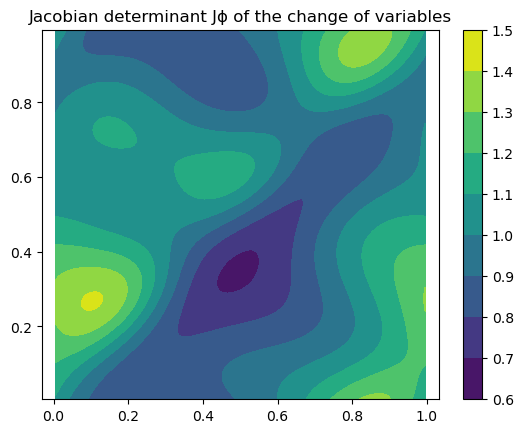

In [89]:
plt.title("Jacobian determinant Jϕ of the change of variables")
plt.contourf(*X,Jϕ)
plt.colorbar()
plt.axis('equal');

Perform the changes of variables in the coefficients.

In [90]:
tρ  = tρ_a(lambda x:ρ, ϕ, Jϕ)
tD  = tD_a(lambda x:D, ϕ, inv_dϕ, Jϕ) 

In [91]:
order_x=2; order_t=2
dt_max = CFL_a(tρ,tD,dx,order_x=order_x,order_t=order_t)
dt = 0.5*dt_max
niter = 100
T = niter*dt

Compute the exact solution.

In [92]:
q0 = tq_a(lambda x:q_exact(0,x), ϕ)
p0 = tp_a(lambda x:p_exact(0,x), ϕ, Jϕ)
q1_exact = tq_a(lambda x:q_exact(T,x), ϕ)
p1_exact = tp_a(lambda x:p_exact(T,x), ϕ, Jϕ)
q1_norm = norm(q1_exact,np.inf) 
p1_norm = norm(p1_exact,np.inf)

Build the Hamiltonian.

In [93]:
WaveH = Hamiltonian_a(tρ,tD,X,dx,order=order_x)

Run the symplectic time integrator.

In [94]:
q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

Check the conservation of the discrete perturbed Hamiltonian, and the scheme accuracy.

In [95]:
WaveH.H_p(q1,p1,dt,order=order_t),WaveH.H_p(q0,p0,dt,order=order_t)

(13287530.137897987, 13287530.13789799)

In [96]:
norm(q1-q1_exact,np.inf)/q1_norm, norm(p1-p1_exact,np.inf)/p1_norm

(0.006101797239235787, 0.0159757519075739)

Finally, as before, we systematically check the accuracy and Hamiltonian conservation of the other schemes.
The fourth order scheme (in time and space) is approximately $10\times$ more accurate than the second order scheme, with $\epsilon=0.02$.

However this is strongly dependent on the smoothness of the change of variables, which becomes more rough as $\epsilon$ increases. Stronger improvements are obtained for smaller values ($60\times$ for $\ve = 0.01$), and smaller improvements for larger values ($3 \times$ for $\ve = 0.05$).

In [97]:
print(f"Parameters {dx=:.2g}, {dt=:.2g}, {niter=}. Change of variables {ϵ=}\n")
for order_x in (2,4):
    WaveH = Hamiltonian_a(tρ,tD,X,dx,order=order_x)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)
        H_num = WaveH.H_p(q1,p1,dt,order=order_t)
        H_exact = WaveH.H_p(q0,p0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(q1-q1_exact,np.inf)/q1_norm
        p1_relerr = norm(p1-p1_exact,np.inf)/p1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.01, dt=0.0012, niter=100. Change of variables ϵ=0.02



Parameters order_x=2, order_t=1
H_relerr=0, q1_relerr=0.0063, p1_relerr=0.017
Parameters order_x=2, order_t=2
H_relerr=-2.8e-16, q1_relerr=0.0061, p1_relerr=0.016
Parameters order_x=2, order_t=4
H_relerr=-1e-11, q1_relerr=0.0064, p1_relerr=0.017
Parameters order_x=4, order_t=1


H_relerr=0, q1_relerr=0.0038, p1_relerr=0.0063
Parameters order_x=4, order_t=2
H_relerr=-4.2e-16, q1_relerr=0.00079, p1_relerr=0.0022
Parameters order_x=4, order_t=4


H_relerr=-4.2e-11, q1_relerr=0.00059, p1_relerr=0.0019


## 3. Two dimensional elastic waves

Let us recall the Hamiltonian of the elastic wave equation : 
\begin{align*}
    2H_e(q,p) &:= \int_X |p|^2_M + |\ve|^2_C, &
    \text{where }
    \ve := \frac 1 2 (\Diff q + \Diff q^\top) - S q,
\end{align*}

*Common simplification.*
One has $M = \Id/\rho$ and $S=0$ in practice, unless a change of variables has been applied, see 
[1.5 Elastic change of variables](#1.5-Elastic-change-of-variables).

**Kinetic energy.**
The first term $\int_X |p|^2_M$ is the kinetic energy, where $p$ is the momentum (density) and $M\succ 0$ is a field of $d\times d$ symmetric positive definite matrix. 

The discretiation of the kinetic energy is straightforward.

In [98]:
def KineticEnergy_e(p,M):
    """Kinetic energy for elasticity."""
    p,M = fd.common_field( (p,M), (1,2) ) # Broadcasting
    return 0.5 * lp.dot_VAV(p,M,p)

Let us choose a constant symmetric positive definite matrix for our experiments.

In [99]:
M = Riemann.from_diagonal([2**2,1]).rotate_by(np.pi/6).m
M

array([[3.25      , 1.29903811],
       [1.29903811, 1.75      ]])

**Selling/Voronoi matrix decomposition of Hooke tensors.**
See the notebooks on the [elastic energy](ElasticEnergy.ipynb), and the [elastic wave equation](ElasticWave.ipynb), for more discussion. 
By decomposing the Hooke tensor $C$, one obtains coefficients $\lambda_i\geq 0$, and matrices $E^i \in \cS_d(\bZ)$ (i.e. $d\times d$ symmetric matrices with integer coefficients), such that :
$$
    |\ve|_C^2 = \sum_{1 \leq i \leq I} \lambda_i \Tr(E^i \ve)^2.
$$
One has $I = 6$ if $d=2$, and $I = 21$ if $d=3$. Let us choose a Hooke tensor, and illustrate this decomposition.

In [100]:
C = mica.extract_xz().rotate_by(np.pi/8).hooke
print(f"Chosen Hooke tensor (using Voigt notation) C=\n{C}.")

Chosen Hooke tensor (using Voigt notation) C=
[[140.58492238  33.8875      41.14871119]
 [ 33.8875      53.54007762   2.37371119]
 [ 41.14871119   2.37371119  31.5875    ]].


In [101]:
λ,E = Hooke(C).Selling()
print(f"Coefficients {λ=}")
print(f"First two matrix offsets : \nE0=\n{E[:,:,0]},\nE1=\n{E[:,:,1]}")

Coefficients λ=array([ 7.1875    ,  2.37371119, 22.02628881, 22.02628881, 51.17371119,
       29.14007762])
First two matrix offsets : 
E0=
[[2 1]
 [1 0]],
E1=
[[-2 -1]
 [-1 -1]]


**Discretization of the elastic potential energy.**
Then observe that for any $E \in \cS_d(\bZ)$, one has assuming  $\ve = \tfrac 1 2 (\Diff q + \Diff q^\top) - S q$
$$
    \Tr(E \ve) = \Tr(E \ \Diff q) - \Tr(E\ S q ) = \sum_{1 \leq j \leq d} \<e_j,\nabla q_j\> - \Tr(E S_j) q_j,
$$
where $e_1,e_2,e_3 \in \bZ^d$ are the columns of $E$, and $S_1,S_2,S_3 \in \cS_d$ are the images of the canonical basis by $S$. The above expression can be discretized on the Cartesian grid using finite differences, e.g.
$$
    \Tr(E \ve(x)) = \sum_{1 \leq i \leq d} \frac{q_j(x+h e_j)-q_j(x)} h - \Tr(E S_j) q_j + \cO(h).
$$


*Numerical scheme symmetry*. The gradient $\<e_j,\nabla q_j\>$ can be discretized using upwind or downwind finite differences, namely $q_j(x+h e_j)-q_j(x)$ or $q_j(x)-q_j(x-h e_j)$. There is no reason to correlate these choices for the different indices $1 \leq j \leq d$, and we thus mix the different possibilities. 

In [102]:
def PotentialEnergy2e(q,C,dx,order=2,S=None):
    """Two dimensional potential elastic energy."""
    λ,E = Hooke(C).Selling()
    λ,E,q,S = fd.common_field( (λ,E,q,S), depths=(1,3,1,3)) # broadcasting
    if S is None: ES = (0,)*len(q)
    else: ES = np.sum(E[:,:,None,:]*S[:,:,:,None],axis=(0,1))
    dq0 = fd.DiffEll(q[0],E[0],dx,order=order,α=ES[0]*q[0],padding=None)
    dq1 = fd.DiffEll(q[1],E[1],dx,order=order,α=ES[1]*q[1],padding=None)
    return (λ/4)*((dq0+dq1)**2+(dq0+dq1[::-1])**2)

In [103]:
def Hamiltonian2e(M,C,X,dx,order=2,S=None):
    """Discretized Hamiltonian of the two dimensional elastic wave equation."""
    Hq = lambda q: PotentialEnergy2e(q,C,dx,order=order,S=S) 
    Hp = lambda p: KineticEnergy_e(p,M)
    H = QuadraticHamiltonian(Hq,Hp)
    H.set_spmat(xp.zeros_like(X)) # Replaces quadratic functions with sparse matrices
    return H

We run these tests on a small domain, since this sparse matrix implementation is not much optimized. 
The specialized GPU kernels presented later in the notebook allow to deal with larger cases.

In [104]:
X,dx = make_domain(80,2)

In [105]:
order_x = 2; order_t = 2
WaveH = Hamiltonian2e(M,C,X,dx)

*CFL condition.*
The following estimate, based on the discussion in the notebooks on [elastic energy](ElasticEnergy.ipynb) and [elastic waves](ElasticWave.ipynb), can be excessively pessimistic for anisotropic $M$.

In [106]:
def CFL_e(M,C,dx,**kwargs):
    """
    Largest time step guaranteed to be stable for the elastic wave equation
    kwargs : see CFL_mult
    """
    hooke = Hooke(C)
    tr = lp.trace(hooke.to_Mandel())
    M = np.moveaxis(M,(0,1),(-2,-1))
    iρ = np.max(np.linalg.eigvalsh(M),axis=-1)    
    return dx/(hooke.vdim*np.sqrt(np.max(iρ*tr))) * CFL_mult(**kwargs)

In [107]:
dt_max = CFL_e(M,C,dx,order_x=order_x,order_t=order_t)
dt = 0.4*dt_max
niter = 100
T = 100*dt

### 3.1 Construction of an exact solution

A similar discussion, with nice animations but not taking $M$ into account, is presented in [the notebook on elastic waves](ElasticWave.ipynb).

The elastic wave PDE, which is Hamilton's equations for the Elastic hamiltonian, reads as follows:
\begin{align*}
    \dot q &= M p, &
    \dot p_i &= \sum_{jkl} \partial^j(C_{ijkl} \partial^k q^l),
\end{align*}
for all $1 \leq i \leq d$, where for simplicity we assumed $S=0$.

Consider a travelling wave 
$$
    q(t,x) = v \ f(\<\kw,x\> - \omega t),
$$
where $v\in \bR^3$ is a vector, $k \in \bR^3$ is the wavenumber, and $\omega$ is the pulsation. 
Define the associated impulsion as 
$$
    p(t,x) := M^{-1} \dot q = -\omega M^{-1} v f'(\<\kw,x\> - \omega t)
$$
Using the second elastic wave equation, we find that $(q,p)$ is a solution iff one has the compatibility condition
\begin{align*}
    \omega^2 v &= M C[\kw] v, & 
    \text{where } C[\kw]_{il} := \sum_{jk} C_{ijkl} \kw^j \kw^k.
\end{align*}
Note that $M$ and $C[\kw]$ are symmetric positive definite matrices by construction, for $\kw\neq 0$. Therefore $M C[\kw]$, which is similar to $M^\frac 1 2 C[\kw] M^{\frac 1 2}$, has $d$ positive eigenvalues.

Given a wavenumber $\kw$, we therefore have $d$ possible choices for $\omega$ and $v$, corresponding to different  eigenvalues. The fastest of these propagation modes is often referred to as the pressure wave, and the others as shear waves; recall that the wave velocity is $\omega/\kw$.

In [108]:
def elastic_modes(M,C,k):
    """
    Returns the propagation modes for the elastic wave equation
    with constant coefficients and a given wavenumber, sorted 
    from slowest to fastest.
    """
    # This code is a slight generalization of the Hooke.waves method
    Ck = Hooke(C).contract(k)
    if xp is np: λ,v = np.linalg.eig(lp.dot_AA(M,Ck))
    else: # cupy has no eig function
        λ,v = np.linalg.eig(ad.cupy_generic.cupy_get(M))
        λ,v = xp.asarray(λ),xp.asarray(v)
    ω = np.sqrt(λ)
    order = np.argsort(ω) # Sort from slowest to fastest
    return ω[order],v[:,order]

In [109]:
k = (1,2)
elastic_modes(M,C,k)

(array([11.90122422, 46.68298566]),
 array([[-0.52437991,  0.86245423],
        [ 0.85148442,  0.50613506]]))

In [110]:
Hooke(C).waves(k,1)

(array([11.89668232, 23.35040411]),
 array([[ 0.53072246, -0.84754567],
        [-0.84754567, -0.53072246]]))

We superpose such modes to construct an exact solution. Similarly to the acoustic case, we take care to use multiples of $2\pi$ as wavenumbers, so as to obtain a periodic solution.

In [111]:
def ExactSol_e(M,C,ks,fs,imodes):
    """
    Produce an exact solution of the elastic wave equation, 
    with constant metric M and Hooke tensor C (and S=0).
    - ks : list of wave numbers.
    - fs : list of functions.
    - imodes : list of integers in [0,...,d-1], the propagation mode number.
    Choose ks with integer coordinates, and fs 1-periodic, to obtain a solution on (R/Z)^2
    """
    vdim = len(D); ks = xp.array(ks)
    modes = [elastic_modes(M,C,k) for k in ks]
    ωs = [ω[i] for (ω,_),i in zip(modes,imodes)]
    vs = [v[:,i] for (_,v),i in zip(modes,imodes)]
    ivs = [lp.solve_AV(M,v) for v in vs]    

    def q(t,x): 
        x_,vs_,ks_ = fd.common_field((x,vs,ks),depths=(1,2,2))
        return sum( v*f(lp.dot_VV(k,x_)-ω*t) for (v,k,ω,f) in zip(vs_,ks_,ωs,fs) )
    
    def p(t,x): 
        x_,ivs_,ks_ = fd.common_field((x,ivs,ks),depths=(1,2,2))
        return sum( -iv*ω*deriv(f,lp.dot_VV(k,x_)-ω*t) for (iv,k,ω,f) in zip(ivs_,ks_,ωs,fs) )

    return q,p

In [112]:
q_exact,p_exact = ExactSol_e(M,C,[
    (1,0),(1,-1),(-2,1) # Wavenumbers
],[
    lambda s:0.5*np.cos(6*π*s+1.2), # Some arbitrary 1-periodic function
    lambda s:np.exp(np.cos(4*π*s+4)), 
    lambda s:np.cos(2*π*s+2)
],[0,1,0]) # Wavemodes

q0 = q_exact(0,X); p0 = p_exact(0,X)
q1_exact = q_exact(T,X); p1_exact = p_exact(T,X)
q1_norm = norm(q1_exact,np.inf); p1_norm = norm(p1_exact,np.inf)

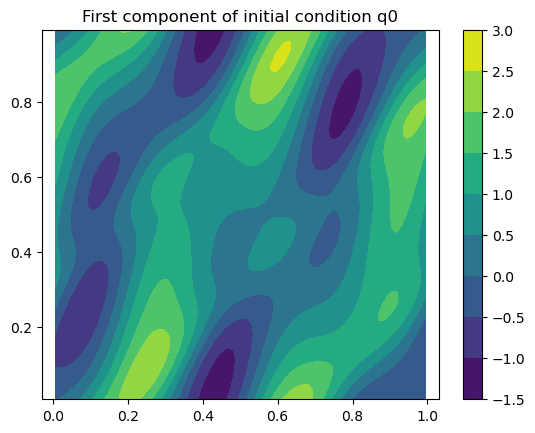

In [113]:
plt.title("First component of initial condition q0")
plt.contourf(*X,q0[1])
plt.colorbar()
plt.axis('equal');

Let us run the symplectic integrator, check the conservation of the discrete perturbed Hamiltonian, and the scheme accuracy.

<!---
## Copied from other notebooks
import itertools

def ElasticEnergy(v,hooke,dom):
    """
    Finite differences approximation of c(ϵ,ϵ), where c is the Hooke tensor and ϵ the strain tensor,
    which is twice the (linearized) elastic energy density.
    """
    d=len(v)
    coefs,moffsets = hooke.Selling()
    dvp = tuple( dom.DiffUpwind(v[i], moffsets[i]) for i in range(d))
    dvm = tuple(-dom.DiffUpwind(v[i],-moffsets[i]) for i in range(d))
    
    # Consistent approximations of Tr(moffset*grad(v))
    dv = ad.array([sum(s) for s in itertools.product(*zip(dvp,dvm))])
    dv2 = (dv**2).sum(axis=0)
    
    coefs = fd.as_field(coefs,v.shape[1:]) * 2**(-d)
    return (coefs*dv2).sum(axis=0) 

def wave(t,x,ω,k,V,ϕ=0.):
    t,x,ω,k,V = fd.common_field((t,x,ω,k,V),depths=(0,1,0,1,1))
    return V*np.cos(lp.dot_VV(k,x)-ω*t+ϕ)

def WaveModes(k,hooke,ρ):
    """Returns the wave modes, sorted by increasing velocity, 
    associated with a given Hooke tensor and wave vector"""
    def wave_(ω,V): return lambda t,x : wave(t,x,ω,k,V)
    ω_,V_ = hooke.waves(k,ρ)
    return [wave_(ω,V) for ω,V in zip(ω_,V_.T)]

def WaveResidue(t,x,v,hooke,ρ):
    # Differentiate twice w.r.t time
    t_ad = ad.Dense2.identity(constant=t)
    v_tt = v(t_ad,x).hessian(0,0)
    
    # Differentiate twice w.r.t position
    x_ad = ad.Dense2.identity(constant=x)
    v_xx = v(t,x_ad).hessian() # Axes ordering : partial derivatives, then coordinates.
    
    # Contract with the Hooke tensor
    d = hooke.vdim
    hk = hooke.to_depth4() # Format hooke tensor as a depth 4 tensor
    Δv = sum(hk[:,j,k,l]*v_xx[j,k,l] for j in range(d) for k in range(d) for l in range(d))

    return ρ*v_tt - Δv

k=[0.6,0.8]
t,x = 1.,[2.,3.]; material = Hooke(C),1
shearW,pressW = WaveModes(k,*material)
assert allclose(WaveResidue(t,x,shearW,*material), 0.)
assert allclose(WaveResidue(t,x,pressW,*material), 0.)

dom = Domain.MockDirichlet(X.shape,dx,padding=None) #Periodic domain (wrap instead of pad)

print(WaveResidue(t,x,lambda t,x:q_exact(x,t), Hooke(C),1))
--->

In [114]:
q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

In [115]:
WaveH.H_p(q1,p1,dt,order=order_t),WaveH.H_p(q0,p0,dt,order=order_t)

(83848126.54488605, 83848126.54488602)

In [116]:
norm(q1-q1_exact,np.inf)/q1_norm, norm(p1-p1_exact,np.inf)/p1_norm

(0.0025992964259300825, 0.009443890767213135)

We perform the same systematic tests as usual. The fourth order scheme in time does not bring much benefit here, in contrast to the fourth order scheme in space. 
Note that the latter is quite costly.

In [117]:
print(f"Parameters {dx=}, {dt=}, {niter=}, {M=}, \n{C=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian2e(M,C,X,dx,order=order_x)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)
        H_num = WaveH.H_p(q1,p1,dt,order=order_t)
        H_exact = WaveH.H_p(q0,p0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(q1-q1_exact,np.inf)/q1_norm
        p1_relerr = norm(p1-p1_exact,np.inf)/p1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert allclose(H_exact,H_num)

Parameters dx=0.0125, dt=7.792738804814531e-05, niter=100, M=array([[3.25      , 1.29903811],
       [1.29903811, 1.75      ]]), 
C=array([[140.58492238,  33.8875    ,  41.14871119],
       [ 33.8875    ,  53.54007762,   2.37371119],
       [ 41.14871119,   2.37371119,  31.5875    ]]).



Parameters order_x=2, order_t=1
H_relerr=1.8e-16, q1_relerr=0.0048, p1_relerr=0.011
Parameters order_x=2, order_t=2
H_relerr=3.6e-16, q1_relerr=0.0026, p1_relerr=0.0094
Parameters order_x=2, order_t=4
H_relerr=5.2e-15, q1_relerr=0.0026, p1_relerr=0.0094


Parameters order_x=4, order_t=1
H_relerr=-1.1e-15, q1_relerr=0.0031, p1_relerr=0.006
Parameters order_x=4, order_t=2
H_relerr=-1.1e-15, q1_relerr=5.4e-05, p1_relerr=0.00014
Parameters order_x=4, order_t=4


H_relerr=-7.1e-16, q1_relerr=6.2e-05, p1_relerr=0.0002


### 3.2 Change of variables

The change of variable formulas for the elastic wave equation were presented in [1.5 Elastic change of variables](#1.5-Elastic-change-of-variables). Let us recall them : 
\begin{align*}
    \tilde q &= \Phi^\top \ q \circ \vp, &
    \tilde p &= \Phi^{-1} \ p \circ \vp \ J, &
    \tilde M &= \Phi^\top \ M\circ \vp \ \Phi / J, &
    \tilde \ve &= \Phi^\top \ \ve \circ \vp \ \Phi.
\end{align*}
Denoting $\Psi := \Phi^{-1}$ we also have in coordinates (do not put too much trust in my upper and lower indices)
\begin{align*}
    \tilde C_{ijkl} &:= \sum_{i'j'k'l'} C_{i'j'k'l'} \circ \vp \ \Psi^{i'}_i \Psi^{j'}_j \Psi^{k'}_k \Psi^{l'}_l \ J,&
    \tilde S_{ij}^k &= \sum_{i'j'} \Phi^{i}_{i'} \Phi^{j}_{j'} \ S^{i'j'}_{k'}\circ \vp \ \Psi_k^{k'} 
    {+} \sum_{k'} \partial^{ij}\phi_{k'} \Psi_k^{k'}
\end{align*}
We use a change of variables that is compatible with the torus domain $(\bR/\bZ)^2$, the same as before, and apply it to the constant coefficient case for which an exact solution is known.

<!---
**Geometric interpretation of $q$ and $p$.**
In the generalized elastic wave equation, when $M\neq \Id/\rho$, the position variable $q$ cannot be interpreted as an infinitesimal displacement anymore, as evidenced by the change of variables $\Phi^\top \ q \circ \vp$ (as opposed to $\Phi \ q \circ \vp$). Rather, $q$ is a co-vector, which is also consistent with the upper indices $q^i$ used the elastic equations. In contrast whereas the momentum density $p$ remains a true vector, living in physical space, which is why we can compute the kinetic energy anyway. 
--->

In [118]:
def tq_e(q,ϕ,dϕ): return lp.dot_AV(lp.transpose(dϕ),q(ϕ))
def tp_e(p,ϕ,inv_dϕ,Jϕ): return lp.dot_AV(inv_dϕ,p(ϕ))*Jϕ

def tM_e(M,ϕ,dϕ,Jϕ): 
    M_ = fd.as_field(M(ϕ),Jϕ.shape,depth=2)
    return lp.dot_AA(lp.transpose(dϕ),lp.dot_AA(M_,dϕ))/Jϕ

def tC_e(C,ϕ,inv_dϕ,Jϕ): 
    C_ = fd.as_field(C(ϕ),Jϕ.shape,depth=2)
    return Hooke(C_).rotate(inv_dϕ).hooke*Jϕ

def tS_e(S,ϕ,dϕ,inv_dϕ,d2ϕ): 
    S_ = fd.as_field(S(ϕ),ϕ[0].shape,depth=3)
    vdim = len(dϕ)
    
    S1 = sum(dϕ[ip,:,None,None]*dϕ[jp,None,:,None]*S_[ip,jp,kp]*inv_dϕ[:,kp]
          for ip in range(vdim) for jp in range(vdim) for kp in range(vdim))
    S2 = sum(d2ϕ[kp,:,:,None]*inv_dϕ[:,kp] for kp in range(vdim))
    return S1 + S2

Let us check, using automatic differentiation, the validity of these implementations.

<!---
# Check tS, first with zeros
S = np.zeros((2,2,2)) 
S1 = tS_e(lambda x:S,ϕ,dϕ,inv_dϕ,d2ϕ) # only second part
q1 = lp.dot_AV(lp.transpose(dϕ),q0)
(S1*q1).sum(axis=2)
assert np.allclose((S1*q1).sum(axis=2), (d2ϕ*q0[:,None,None]).sum(axis=0))
--->

In [119]:
ϵ = 0.02
ϕ,dϕ,inv_dϕ,Jϕ,d2ϕ = differentiate(lambda x:ϕ_fun(x,ϵ),X)
assert np.min(Jϕ)>0

# Check the conservation of the duality bracket
q0 = q_exact(0,X); p0=p_exact(0,X)
tq0 = tq_e(lambda x:q_exact(0,x),ϕ,dϕ)
tp0 = tp_e(lambda x:p_exact(0,x),ϕ,inv_dϕ,Jϕ)
assert allclose(np.sum(tq0*tp0),np.sum(q0*p0),atol=1e-8 if xp is np else 1e-2)

# Check the conservation of the kinetic energy
tM = tM_e(lambda x:M,ϕ,dϕ,Jϕ)
assert allclose(KineticEnergy_e(tp0,tM).sum(), KineticEnergy_e(p0,M).sum())

# Check the Hooke tensor transformation, linear part only
def ϵ_fun(x):
    x_ad = ad.Dense.identity(constant=x,shape_free=(2,))
    dq = np.moveaxis(q_exact(0,x_ad).coef,-1,1) # Differential
    return 0.5*(dq+lp.transpose(dq))
ϵ = ϵ_fun(X)
ϵ1 = lp.dot_AA(lp.transpose(dϕ),lp.dot_AA(ϵ,dϕ))
assert allclose(Hooke(C).dot_AA(ϵ,ϵ), Hooke(C).rotate(inv_dϕ).dot_AA(ϵ1,ϵ1))

# Check the Hooke tensor transformation, with the coordinate transform
tC = tC_e(lambda x:C,ϕ,inv_dϕ,Jϕ)
tϵ = lp.dot_AA(lp.transpose(dϕ),lp.dot_AA(ϵ_fun(ϕ),dϕ))
assert allclose(Hooke(C).dot_AA(ϵ,ϵ).sum(),Hooke(tC).dot_AA(tϵ,tϵ).sum())
# Weird that it works so well, there should be some small error.

# Check tS, with some random values
np.random.seed(42)
S = xp.asarray(np.random.rand(2,2,2,*Jϕ.shape)); S = S+np.moveaxis(S,0,1) # Symmetrize
S1 = tS_e(lambda x:S,ϕ,dϕ,inv_dϕ,d2ϕ) # only second part
s1 = lp.dot_AA(lp.transpose(dϕ),lp.dot_AA((S*q0).sum(axis=2),dϕ))
s2 = (d2ϕ*q0[:,None,None]).sum(axis=0)
q1 = lp.dot_AV(lp.transpose(dϕ),q0)
assert allclose(s1+s2, (S1*q1).sum(axis=2))

# Check the conservation of the Potential energy
S = xp.zeros((2,2,2))
tS = tS_e(lambda x:S,ϕ,dϕ,inv_dϕ,d2ϕ)
for order in (2,4):
    tE = PotentialEnergy2e(tq0,tC,dx,S=tS,order=order).sum()
    E = PotentialEnergy2e(q0,C,dx,S=S,order=4).sum()
    print(f"Finite differences energy relative error : {tE/E-1:.3g}, {order=}")
    # Only accurate up to the scheme truncation error

Finite differences energy relative error : 0.00345, order=2
Finite differences energy relative error : 6.68e-05, order=4


Let us build the scheme, run it, and check the discrete perturbed hamiltonian conservation and numerical error.

In [120]:
WaveH = Hamiltonian2e(tM,tC,X,dx,order=2,S=tS)

In [121]:
dt_max = CFL_e(tM,tC,dx)
dt = 0.4*dt_max
niter = 100
T = 100*dt

In [122]:
q0 = tq_e(lambda x:q_exact(0,x),ϕ,dϕ)
p0 = tp_e(lambda x:p_exact(0,x),ϕ,inv_dϕ,Jϕ)
q1_exact = tq_e(lambda x:q_exact(T,x),ϕ,dϕ)
p1_exact = tp_e(lambda x:p_exact(T,x),ϕ,inv_dϕ,Jϕ)
q1_norm = norm(q1_exact,np.inf); p1_norm = norm(p1_exact,np.inf)

q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)

In [123]:
WaveH.H_p(q1,p1,dt,order=order_t),WaveH.H_p(q0,p0,dt,order=order_t)

(83945071.09771943, 83945071.09772217)

In [124]:
norm(q1-q1_exact,np.inf)/q1_norm, norm(p1-p1_exact,np.inf)/p1_norm

(0.007253681870753503, 0.01803895519800285)

In [125]:
print(f"Parameters {dx=}, {dt=}, {niter=}, {M=}, \n{C=}.\n")
for order_x in (2,4):
    WaveH = Hamiltonian2e(tM,tC,X,dx,order=order_x,S=tS)
    for order_t in (1,2,4):
        print(f"Parameters {order_x=}, {order_t=}")
        q1,p1 = WaveH.Sympl_p(q0,p0,dt,niter,order=order_t)
        H_num = WaveH.H_p(q1,p1,dt,order=order_t)
        H_exact = WaveH.H_p(q0,p0,dt,order=order_t)
        H_relerr = (H_num-H_exact)/H_exact
        q1_relerr = norm(q1-q1_exact,np.inf)/q1_norm
        p1_relerr = norm(p1-p1_exact,np.inf)/p1_norm
        print(f"{H_relerr=:.2g}, {q1_relerr=:.2g}, {p1_relerr=:.2g}")
        assert np.allclose(H_exact,H_num)

Parameters dx=0.0125, dt=5.903383474983559e-05, niter=100, M=array([[3.25      , 1.29903811],
       [1.29903811, 1.75      ]]), 
C=array([[140.58492238,  33.8875    ,  41.14871119],
       [ 33.8875    ,  53.54007762,   2.37371119],
       [ 41.14871119,   2.37371119,  31.5875    ]]).



Parameters order_x=2, order_t=1
H_relerr=0, q1_relerr=0.0087, p1_relerr=0.019
Parameters order_x=2, order_t=2
H_relerr=0, q1_relerr=0.0073, p1_relerr=0.018
Parameters order_x=2, order_t=4


H_relerr=-3.3e-14, q1_relerr=0.0073, p1_relerr=0.018


Parameters order_x=4, order_t=1
H_relerr=-1.8e-16, q1_relerr=0.0036, p1_relerr=0.0099
Parameters order_x=4, order_t=2
H_relerr=0, q1_relerr=0.0014, p1_relerr=0.0084
Parameters order_x=4, order_t=4


H_relerr=-8.1e-14, q1_relerr=0.0014, p1_relerr=0.0084


## 4. GPU accelerated kernels

Generic sparse matrix libraries are usually quite efficient on the CPU. In contrast, on the GPU, when the sparsity patterns are known, a custom kernel usually provides a substantial speedup and as importantly can be much more memory efficient. 

The point of this section is only to check reproducibility. We do not run large test cases here.
We compare the above implementation, which eventually relies on sparse matrices, with another implementation based on GPU kernels.

In [126]:
from agd.Eikonal.HFM_CUDA import AnisotropicWave as aw
# Sparse matrix implementations, intended for CPU, as illustrated above
aw.AcousticHamiltonian_Sparse, aw.ElasticHamiltonian_Sparse
# GPU kernel implementations, should be equivalent
aw.AcousticHamiltonian_Kernel, aw.ElasticHamiltonian_Kernel

(agd.Eikonal.HFM_CUDA.AnisotropicWave.AcousticHamiltonian_Kernel,
 agd.Eikonal.HFM_CUDA.AnisotropicWave.ElasticHamiltonian_Kernel)

In [127]:
try: import cupy as cp
except ImportError: raise ad.DeliberateNotebookError("Cuda GPU needed for this section")

DeliberateNotebookError: Cuda GPU needed for this section

### 4.1 Acoustic wave 

In [129]:
np.random.seed(42)
rand = np.random.rand

for vdim in (1,2,3,): 
    nX = (None,10,5,5)[vdim]
    tol = (None,1e-5,1e-4,1e-3)[vdim]
    tols = {'rtol':tol,'atol':tol}
    shape = (nX,)*vdim
    dx = 1/nX
    np.random.seed(42)
    ρ = rand(*shape)
    D = rand(vdim,vdim,*shape)-0.5
    D = lp.dot_AA(lp.transpose(D),D)
    for i in range(vdim): D[i,i]+=0.1
#    D[:] = np.eye(vdim).reshape((vdim,vdim)+(1,)*vdim) # Variant : identity matrix

    q0_cpu,p0_cpu = rand(*shape),rand(*shape)
#    q0_cpu = 1+0*q0_cpu # Variant : constant position
#    q0_cpu = 0*q0_cpu; q0_cpu[(0,)*vdim]=1 # Variant : Dirac position
    dt = 0.1
    damp_p = rand(*shape)
    damp_q = rand(*shape)

    ρ_gpu,D_gpu,damp_q_gpu,damp_p_gpu,q0_gpu,p0_gpu = [cp.asarray(e,dtype=np.float32) 
        for e in (ρ,D,damp_q,damp_p,q0_cpu,p0_cpu)]

    for order_x in (2,4,): #(2,4):
        print(f"Testing {vdim=}, {order_x=}")
        H_cpu = aw.AcousticHamiltonian_Sparse(ρ,D,dx,order_x=order_x)
        H_cpu.damp_q = damp_q
        H_cpu.damp_p = damp_p

        H_gpu = aw.AcousticHamiltonian_Kernel(ρ_gpu,D_gpu,dx,bc='Periodic',order_x=order_x)
        H_gpu.damp_q = damp_q_gpu
        H_gpu.damp_p = damp_p_gpu

        # Testing
        q1_cpu = H_cpu.Expl_q(q0_cpu,p0_cpu,dt)
        q1_gpu = H_gpu.Expl_q(q0_gpu,p0_gpu,dt)
        assert allclose(q1_cpu,q1_gpu)

        p1_cpu = H_cpu.Expl_p(q0_cpu,p0_cpu,dt)
        p1_gpu = H_gpu.Expl_p(q0_gpu,p0_gpu,dt)
        assert allclose(p1_cpu,p1_gpu,**tols)

        q1_cpu,p1_cpu = H_cpu.Verlet_p(q0_cpu,p0_cpu,dt,niter=2)
        q1_gpu,p1_gpu = H_gpu.Verlet_p(q0_gpu,p0_gpu,dt,niter=2)
        assert allclose(q1_cpu,q1_gpu,**tols)
        assert allclose(p1_cpu,p1_gpu,**tols)

        q1_cpu,p1_cpu = H_cpu.Ruth4_p(q0_cpu,p0_cpu,dt,niter=2)
        q1_gpu,p1_gpu = H_gpu.Ruth4_p(q0_gpu,p0_gpu,dt,niter=2)
        assert allclose(q1_cpu,q1_gpu,**tols)
        assert allclose(p1_cpu,p1_gpu,**tols)

Testing vdim=1, order_x=2
Testing vdim=1, order_x=4
Testing vdim=2, order_x=2
Testing vdim=2, order_x=4
Testing vdim=3, order_x=2
Testing vdim=3, order_x=4


### 4.2 Elastic wave

In [ ]:
rand = np.random.rand
np.random.seed(42)

def MakeRandomTensor(dim, shape=tuple(), relax=0.05):
    A = np.random.standard_normal( (dim,dim) + shape )
    D = lp.dot_AA(lp.transpose(A),A)
    identity = np.eye(dim).reshape((dim,dim)+(1,)*len(shape))
    return D+lp.trace(D)*relax*identity

for vdim in (1,2,3,): 
    nX = (None,10,5,5)[vdim]
    tol = (None,1e-5,1e-4,1e-4)[vdim]
    tols = {'atol':tol,'rtol':tol}
    shape = (nX,)*vdim
    dx = 1/nX
    np.random.seed(42)
    M = MakeRandomTensor(vdim,shape,0.2); M/=np.max(M)
    #M[:] = np.eye(vdim).reshape((vdim,vdim)+(1,)*vdim) # Alternative : M = Id
    #M = np.ones((1,1,*shape)) # Alternative : M = 1

    symdim = (vdim*(vdim+1))//2	
    C = MakeRandomTensor(symdim,shape,0.3); C/=np.max(C)
#    C[:] = np.eye(symdim).reshape((symdim,symdim)+(1,)*vdim) # Alternative : C = Id

    q0_cpu,p0_cpu = rand(vdim,*shape),rand(vdim,*shape)
    #q0_cpu = 1+0*q0_cpu # Alternative : q0 is constant
    #q0_cpu = 0*q0_cpu; q0_cpu[0,(0,)*vdim]=1 # Alternative : q0 is a Dirac
    dt = 0.1
    damp_p = rand(*shape)
    damp_q = rand(*shape)

    for order_x in (2,4,):#(2,4,): #(2,4):
        print(f"Testing {vdim=}, {order_x=}")
        H_cpu = aw.ElasticHamiltonian_Sparse(M,C,dx,order_x=order_x)
        H_cpu.damp_q = damp_q
#        H_cpu.damp_p = damp_p

        H_gpu = aw.ElasticHamiltonian_Kernel(M,C,dx,bc='Periodic',order_x=order_x)
        H_gpu.damp_q = damp_q
        rsh,ush = H_gpu.reshape,H_gpu.unshape
        q0_gpu = rsh(q0_cpu); p0_gpu = rsh(p0_cpu)

        # Testing
        q1_cpu = H_cpu.Expl_q(q0_cpu,p0_cpu,dt)
        q1_gpu = H_gpu.Expl_q(q0_gpu,p0_gpu,dt)
        assert allclose(q1_cpu,ush(q1_gpu))

        p1_cpu = H_cpu.Expl_p(q0_cpu,p0_cpu,dt)
        p1_gpu = H_gpu.Expl_p(q0_gpu,p0_gpu,dt)
        assert allclose(p1_cpu,ush(p1_gpu),**tols)

        q1_cpu,p1_cpu = H_cpu.Verlet_p(q0_cpu,p0_cpu,dt,niter=2)
        q1_gpu,p1_gpu = H_gpu.Verlet_p(q0_gpu,p0_gpu,dt,niter=2)
        assert allclose(q1_cpu,ush(q1_gpu),**tols)
        assert allclose(p1_cpu,ush(p1_gpu),**tols)

        q1_cpu,p1_cpu = H_cpu.Ruth4_p(q0_cpu,p0_cpu,dt,niter=2)
        q1_gpu,p1_gpu = H_gpu.Ruth4_p(q0_gpu,p0_gpu,dt,niter=2)
        assert allclose(q1_cpu,ush(q1_gpu),**tols)
        assert allclose(p1_cpu,ush(p1_gpu),**tols)

Testing vdim=1, order_x=2
Testing vdim=1, order_x=4
Testing vdim=2, order_x=2
Testing vdim=2, order_x=4
Testing vdim=3, order_x=2
